# 5. Machine Learning Models - 1

In [1]:
#importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import os

import warnings
warnings.filterwarnings('ignore')

## 5.1 Utility Functions

### 5.1.1 Upsampling function

- Created this below function for upsampling positive(Y = 1) class training data points.
- Below function uses SMOTE algorithm implemented in imblearn library. 

In [2]:
# ovrsampling training data only
# Ref: https://beckernick.github.io/oversampling-modeling/
from imblearn.over_sampling import SMOTE
def SMOTE_upsmapling(X, Y):
    smote = SMOTE()
    print('class label counts before upsampling :',np.bincount(Y.values.ravel()))
    X_ups,Y_ups = smote.fit_sample(X, Y)
    print('class label counts after upsampling :',np.bincount(Y_ups.values.ravel()))
    print('shapes after upsampling :',X_ups.shape, Y_ups.values.reshape(-1,).shape)
    return X_ups, Y_ups.values.reshape(-1,)

### 5.1.2 utility function for Hyperparameter tuning and for extracting & saving result values.

model_hyperparameter_tuning:
- When this function is given with Classifier object, Parameters list and training set(X and Y) , it performs hyperparameter tuning with the help of RandomizedSearchCV of sklearn and returns best estimator.
- scoring parameter is choosen as 'recall' to evaluate the models.
- n_iter(i.e.,number of parameter settings to be sampled) is choosen as 15.

cost_function:
- This function computes cost value when predicted-Y and actual-Y values are given.

score_table:
- This function prints score table by computing 'Recall', 'Precision', 'F1-score' and 'cost' of the given trained classifier for each of the datsets.
- When the parameter threshold is given with some value, the predicted class labels for the score calculation are computed based on the threshold value. If threshold value is not passed then scores are calculated from the predict() of the classifier.

plot_roc_curve:
- This function plots roc-curves for train, cv and test data by computing fpr and tpr for different thresholds. And it also report AUC values inside the plot.

plot_confusion_matrix:
- This function computes confusion, precision and recall matrices and plots heatmaps for them when predicted-Y and actual-Y values are given.

select_threshold:
- This function returns best threshold value when a trained classifier model and CrossValidation data is given.
- The threshold value, for which the cost value is low, is considered to be the best threshold.
- This function also plots 'Cost vs Threshold' & 'Precision&Recall vs Threshold'

save_results:
- This function saves the result in a csv files with column names:
  - 'Imputation': Imputation method used to impute missing data.
  - 'Model': Name of the classifier model
  - 'Threshold': Best Threshold value
  - 'Cost': fp*10 + fn*500 (cost obtained for the bes threshold value)
  - 'Feature Engineering': details about the feature engineering used in the dataset
  - 'Recall', 'Precision', 'F1-Score', '#FalsePostives', '#FalseNegatives'

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc

def model_hyperparameter_tuning(classifier, parameters, X_train, Y_train):

    model = RandomizedSearchCV(estimator=classifier,n_jobs= -1,\
                               param_distributions=parameters,scoring='recall',\
                               verbose =5, n_iter = 15)
    model.fit(X_train,Y_train)
    print("Best parameters are:\n", model.best_params_)
    print("\nBest estimator is:\n", model.best_estimator_)
    print("\nAnd it's best recall score is :", model.best_score_)
    return model.best_estimator_

def cost_function(y_true, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    return fp*10 + fn*500

def score_table(classifier, datasets, threshold = 'default'):
    table = PrettyTable()
    table.field_names = ["Data", "Recall", "Precison", "F1-score","Cost"]
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        if threshold == 'default':
            Y_pred = classifier.predict(X)
        else:
            Y_pred = (classifier.predict_proba(X)[:,1] > threshold).astype(int)
        recall = np.round(recall_score(Y,Y_pred), 4)
        precision = np.round(precision_score(Y,Y_pred), 4)
        f1 = np.round(f1_score(Y,Y_pred), 4)
        cost = cost_function(Y, Y_pred)
        table.add_row([data, recall, precision, f1, cost ])
    print(table)
    
def plot_roc_curve(classifier, datasets):
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        Y_pred_prob = classifier.predict_proba(X)[:,1] 
        fpr, tpr, thresholds = roc_curve(Y, Y_pred_prob)
        plt.plot(fpr, tpr, label= data+ " AUC ="+str(auc(fpr, tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

def plot_confusion_matrix(y_true, y_predicted):
    class_labels = ['negative','positive']
    
    confusion_matrix_ = confusion_matrix(y_true, y_predicted)
    Precision_matrix = (confusion_matrix_/confusion_matrix_.sum(axis=0))
    recall_matrix = (((confusion_matrix_.T)/(confusion_matrix_.sum(axis=1))).T)
   
    plt.figure(figsize=(20,5))
    plt.suptitle("Confusion, Precison & Recall Matrix", fontsize=24)

    plt.subplot(1, 3, 1)
    sns.heatmap(confusion_matrix_, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(Precision_matrix, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(recall_matrix, annot=True, fmt=".3f", xticklabels=class_labels, yticklabels=class_labels, cmap = 'YlGn')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title("Recall matrix")    
    plt.show()

    tn, fp, fn, tp = confusion_matrix_.ravel()
    cost = fp*10 + fn*500
    print('#False positives(Type 1 error) :', fp)
    print('#False negatives(Type 2 error) :', fn)
    print('cost :', cost)
    
def select_threshold(Y, Y_pred_prob):
    #Y_pred_prob = classifier.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(Y, Y_pred_prob)
    thresholds = np.append(thresholds,1)

    costs_array = []

    for threshold in thresholds:
        Y_hat = Y_pred_prob > threshold
        costs_array.append(cost_function(Y, Y_hat))
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,2,1)
    plt.plot(thresholds, costs_array, label='Costs', linestyle = 'solid', linewidth = 2)
    plt.xlabel("Thresholds")
    plt.ylabel("Costs")
    plt.title("Cost vs Threshold Plot")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(thresholds, precision, label='Precision', linestyle = 'solid', linewidth = 2)
    plt.plot(thresholds, recall, label='Recall', linestyle = 'solid', linewidth = 2)
    plt.xlabel("Thresholds")
    plt.ylabel("Precision & Recall")
    plt.title("Precision&Recall vs Threshold Plot")    
    plt.grid()
    plt.legend()

    plt.show()
    
    best_threshold_index = np.argsort(costs_array)[0]
    best_threshold = thresholds[best_threshold_index]
    min_cost = costs_array[best_threshold_index]
    print("Best threshold: {:.4f}".format(best_threshold))
    print("cost at this thresold: {:.2f}".format(min_cost))
    return best_threshold

def save_results(classifier,imp_meth, threshold,Y, Y_pred, feat_eng ):
    column_names = ['Imputation','Model','Threshold', 'Recall', \
                    'Precision', 'Cost', 'F1-Score', '#FalsePostives',\
                    '#FalseNegatives','Feature Engineering']
    
    if not os.path.isfile('ML models & Results/results.csv'):
        results = pd.DataFrame(columns = column_names)
    else:
        results = pd.read_csv('ML models & Results/results.csv')
    recall = np.round(recall_score(Y,Y_pred), 4)
    precision = np.round(precision_score(Y,Y_pred), 4)
    f1 = np.round(f1_score(Y,Y_pred), 4) 
    tn, fp, fn, tp = confusion_matrix(y_test, Y_pred).ravel()
    cost = fp*10 + fn*500
    row = pd.DataFrame([[imp_meth, classifier, threshold, recall, precision, cost, f1, fp, fn, feat_eng ]],\
                       columns = column_names)
    results = results.append(row,ignore_index=True)
    results.to_csv('ML models & Results/results.csv')

### 5.1.3 Functions for implementing MetaLearnClassifier 

train_metaLearnClassifier:
- Splits the whole training data into into 2 datasets D1(x_train1, y_train1) and D2(x_train2, y_train2).
- Trains k different base classifier models(here we are training DecisionTreeClassifier) on k different variations of D1(sampled with replacement).
- D2(x_train2) is passed to each of these k base models and a new dataset(with each row containing these k predictions) is prepared.
- This prepared dataset along with ground truth values of D2 are used for training meta-model.
- All these k base models along with one meta model are stored in a list and it is returned out.

pred_y_metaLearnClassifier:
- This function takes dataset and list of models and predicts class-label(and also predict probabilities).
- The dataset is passed through k base models and a new dataset is formed with these k predictions.
- These predictions dataset is passed through the meta model and here final predictions are computed and returned.
- As this function predicts y value, it can be used for model evaluation also.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

def train_metaLearnClassifier(x_train,y_train, k):
    x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train,test_size=0.5,stratify = y_train)
    model = dict()
    train2_predictions = np.zeros((len(x_train2), k))
    for i in range(k):
        df_x, df_y = resample(x_train1, y_train1, replace = True)
        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(df_x, df_y)
        model[i] = clf
        train2_predictions[:,i] = model[i].predict(x_train2)

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(train2_predictions, y_train2)
    model[k] = clf
    return model

def pred_y_metaLearnClassifier(x, model, prob = False):
    k = len(model)-1
    k_predictions = np.zeros((len(x),k))
    for i in range(k):
        k_predictions[:,i] = model[i].predict(x)
    if prob == True:
        y_test_pred = model[k].predict_proba(k_predictions)
    else:
        y_test_pred = model[k].predict(k_predictions)
    return y_test_pred

### 5.1.4 utility function for MetaLearnClassifier: Hyperparameter tuning, Computing and reporting scores of classifier model

hyperparameter_tuning_kflod_metaLearnClassifier:
- When this function is given with the training set(X and Y), it performs hyperparameter tuning for metaLearnClassifier with k values(= [2,3,4,5,6,7,8,9,10]) and finds the best 'k' value which has the highest recall score.
- This function returns best 'k' value and it's corresponding recall score value.
- This function performs 5-fold cross validation to choose 'k' value

score_table_metaLearnClassifier:
- This function prints score table by computing 'Recall', 'Precision', 'F1-score' and 'cost' of the given trained metaLearnClassifier for each of the datsets.
- When the parameter threshold is given with some value, the predicted class labels for the score calculation are computed based on the threshold value. If threshold value is not passed then scores are calculated from the predict() of the classifier.

plot_roc_curve_metaLearnClassifier:
- This function plots roc-curves for train, cv and test data by computing fpr and tpr for different thresholds. And it also report AUC values inside the plot.

In [5]:
from sklearn.model_selection import KFold

def hyperparameter_tuning_kflod_metaLearnClassifier(x,y):
    k = [2,3,4,5,6,7,8,9,10, 11, 12]
    train_recall_scores = np.zeros((len(k)))
    test_recall_scores = np.zeros((len(k)))
    for i in range(len(k)):
        kf = KFold(n_splits=5)
        fold_recall_scores = np.array([])
        for train_index, test_index in kf.split(x):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model = train_metaLearnClassifier(x_train,y_train, k[i])
            y_train_pred = pred_y_metaLearnClassifier(x_train, model)
            y_test_pred = pred_y_metaLearnClassifier(x_test, model)
            train_fold_recall_scores = np.concatenate([fold_recall_scores, [recall_score(y_train,y_train_pred)]])
            test_fold_recall_scores = np.concatenate([fold_recall_scores, [recall_score(y_test,y_test_pred)]])
        train_recall_scores[i] = np.mean(train_fold_recall_scores)
        test_recall_scores[i] = np.mean(test_fold_recall_scores)
    print("Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :\n", test_recall_scores)
    plot_recallScores_vs_k(k,train_recall_scores,test_recall_scores)
    max_recall_arg = np.argmax(test_recall_scores)
    best_recall_score = test_recall_scores[max_recall_arg]
    best_k = k[max_recall_arg]
    return best_k, best_recall_score

def plot_recallScores_vs_k(k,train_recall_scores,test_recall_scores):
    plt.plot(k, train_recall_scores)
    plt.plot(k, test_recall_scores)
    plt.scatter(k, train_recall_scores, label='Train Recall Score')
    plt.scatter(k, test_recall_scores, label='Test Recall Score')
    plt.legend()
    plt.xlabel("K(number of base classifiers): hyperparameter")
    plt.ylabel("Recall Score")
    plt.title("Recall Score vs K(number of base classifiers)")
    plt.grid()
    plt.show()

def score_table_metaLearnClassifier(model, datasets, threshold = 'default'):
    table = PrettyTable()
    table.field_names = ["Data", "Recall", "Precison", "F1-score","Cost"]
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        if threshold == 'default':
            Y_pred = pred_y_metaLearnClassifier(X, model)
        else:
            Y_pred = (pred_y_metaLearnClassifier(X, model, prob = True)[:,1] > threshold).astype(int)
        recall = np.round(recall_score(Y,Y_pred), 4)
        precision = np.round(precision_score(Y,Y_pred), 4)
        f1 = np.round(f1_score(Y,Y_pred), 4)
        cost = cost_function(Y, Y_pred)
        table.add_row([data, recall, precision, f1, cost ])
    print(table)

def plot_roc_curve_metaLearnClassifier(classifier, datasets):
    for X,Y,data in [(datasets[0], y_train, "train"),(datasets[1], y_cv, "CV"), (datasets[2], y_test, "test")]:
        Y_pred_prob = pred_y_metaLearnClassifier(X, classifier, prob = True)[:,1]
        fpr, tpr, thresholds = roc_curve(Y, Y_pred_prob)
        plt.plot(fpr, tpr, label= data+ " AUC ="+str(auc(fpr, tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.grid()
    plt.show()

In [6]:
#Loading y_train, y_cv and y_test
y_train = pd.read_csv('y_train.csv', header = None)
y_cv = pd.read_csv('y_cv.csv', header = None)
y_test = pd.read_csv('y_test.csv', header = None)

## 5.2 Median Imputed Dataset

### 5.2.1 loading Train, CV & Test datasets & Upsampling train dataset

In [7]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_med = pd.read_csv('x_tr_med.csv')
x_cv_med = pd.read_csv('x_cv_med.csv')
x_te_med = pd.read_csv('x_te_med.csv')

print('Shapes of Train, CV & Test data of :')
print(x_tr_med.shape, x_cv_med.shape, x_te_med.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_med,y_train = SMOTE_upsmapling(x_tr_med, y_train)

Shapes of Train, CV & Test data of :
(51000, 170) (9000, 170) (16000, 170)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 170) (100300,)


### 5.2.2 LogisticRegression on Median Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   22.0s finished


Best parameters are:
 {'penalty': 'l2', 'C': 10000}

Best estimator is:
 LogisticRegression(C=10000, random_state=42)

And it's best recall score is : 0.9529411764705881

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8374 |  0.9914  |  0.9079  | 4079650 |
|   CV  | 0.7867 |  0.6211  |  0.6941  |  16720  |
|  test | 0.808  |  0.6998  |   0.75   |  37300  |
+-------+--------+----------+----------+---------+


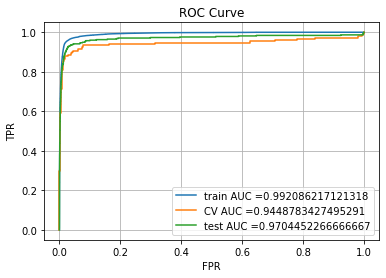

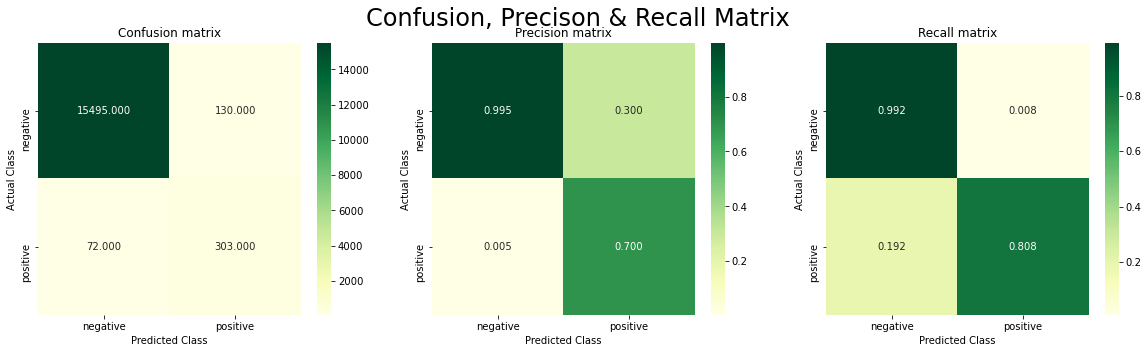

#False positives(Type 1 error) : 130
#False negatives(Type 2 error) : 72
cost : 37300
Selecting best threshold that gives lowest cost


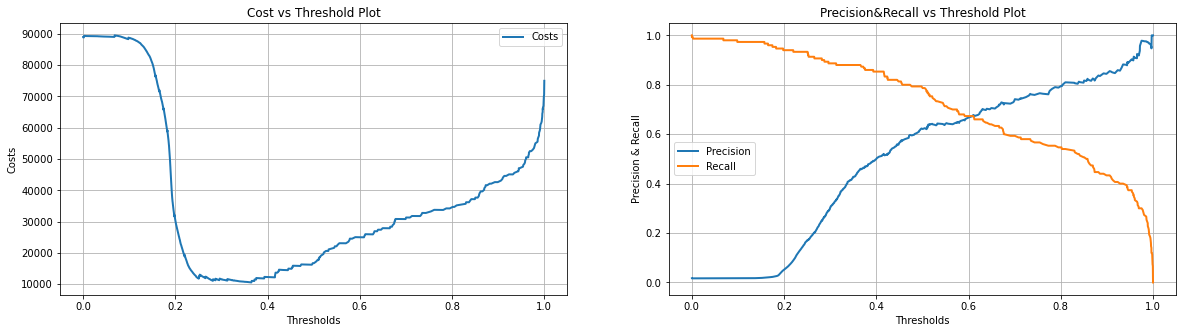

Best threshold: 0.3648
cost at this thresold: 10550.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.9445 |  0.9813  |  0.9625  | 1401050 |
|   CV  |  0.88  |  0.4599  |  0.6041  |  10550  |
|  test | 0.8907 |  0.5361  |  0.6693  |  23390  |
+-------+--------+----------+----------+---------+


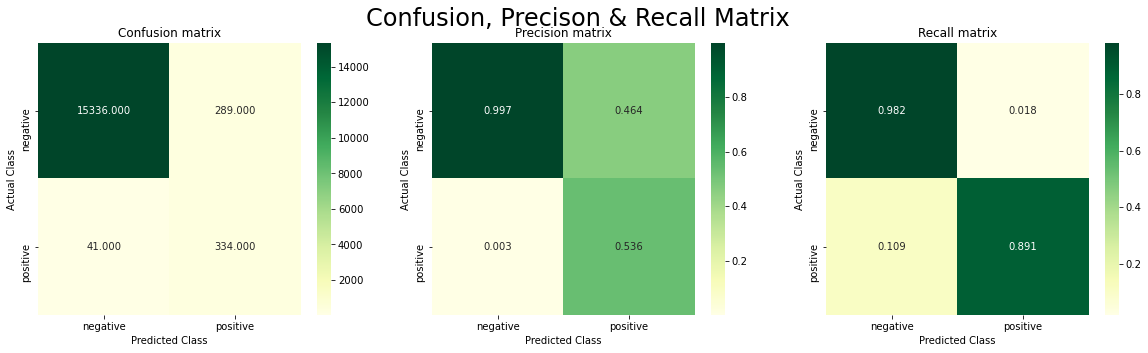

#False positives(Type 1 error) : 289
#False negatives(Type 2 error) : 41
cost : 23390


['ML models & Results/med_LR.pkl']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med, y_train))
best_clf.fit(x_tr_med,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LogisticRegression','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_LR.pkl')

### 5.2.3 LinearSVC on Median Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.3min finished


Best parameters are:
 {'penalty': 'l2', 'C': 1}

Best estimator is:
 LinearSVC(C=1, random_state=42)

And it's best recall score is : 0.954456630109671

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.7751 |  0.9924  |  0.8704  | 5641490 |
|   CV  | 0.7067 |  0.6543  |  0.6795  |  22560  |
|  test | 0.7733 |  0.7323  |  0.7523  |  43560  |
+-------+--------+----------+----------+---------+


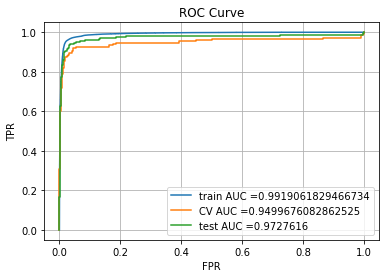

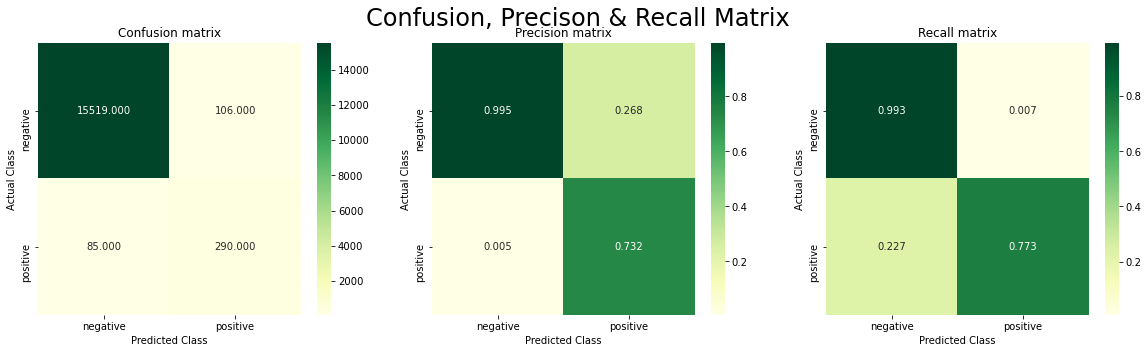

#False positives(Type 1 error) : 106
#False negatives(Type 2 error) : 85
cost : 43560
Selecting best threshold that gives lowest cost


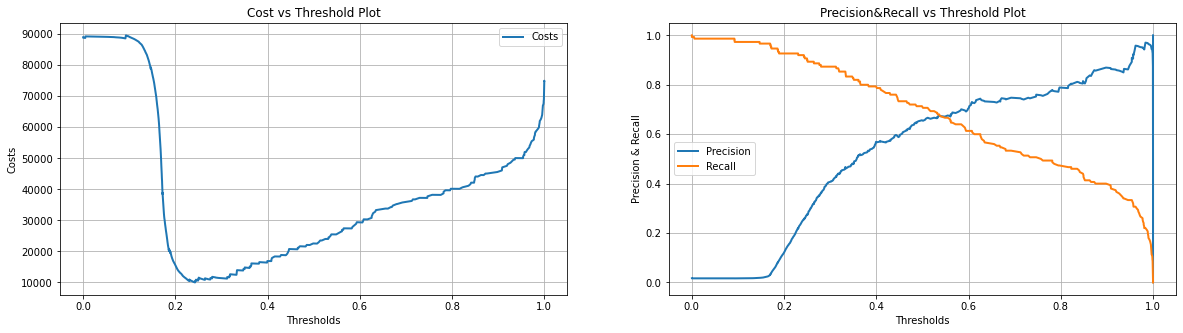

Best threshold: 0.2427
cost at this thresold: 10000.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9722 |  0.9575  |  0.9648  | 718640 |
|   CV  |  0.92  |  0.2565  |  0.4012  | 10000  |
|  test | 0.9413 |  0.3431  |  0.5028  | 17760  |
+-------+--------+----------+----------+--------+


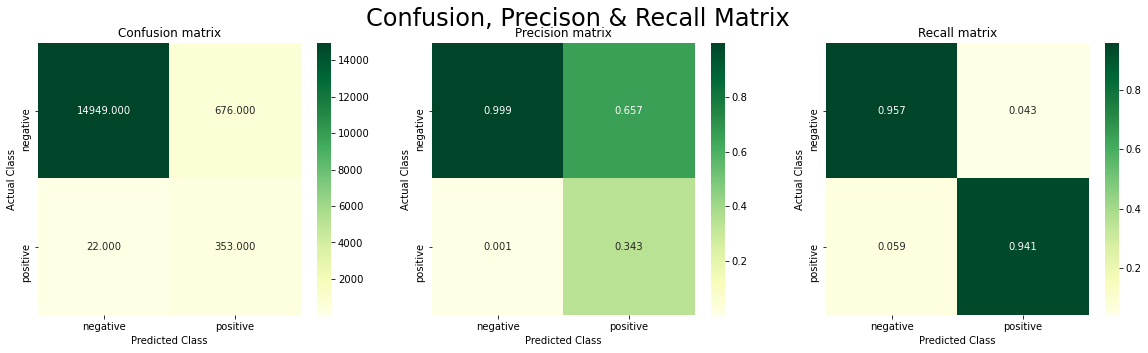

#False positives(Type 1 error) : 676
#False negatives(Type 2 error) : 22
cost : 17760


['ML models & Results/med_SVM.pkl']

In [16]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med, y_train))
best_clf.fit(x_tr_med,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LinearSVM','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_SVM.pkl')

### 5.2.4 RandomForestClassifier on Median Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 61.4min finished


Best parameters are:
 {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_split=8, n_estimators=1000,
                       random_state=42)

And it's best recall score is : 0.9908873379860419

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9912 |  0.9892  |  0.9902  | 225410 |
|   CV  |  0.9   |  0.4945  |  0.6383  |  8880  |
|  test | 0.9067 |  0.6159  |  0.7335  | 19620  |
+-------+--------+----------+----------+--------+


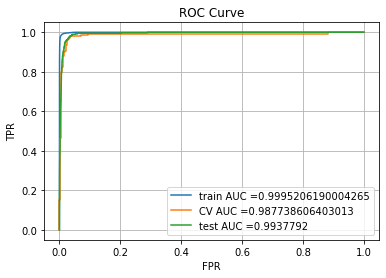

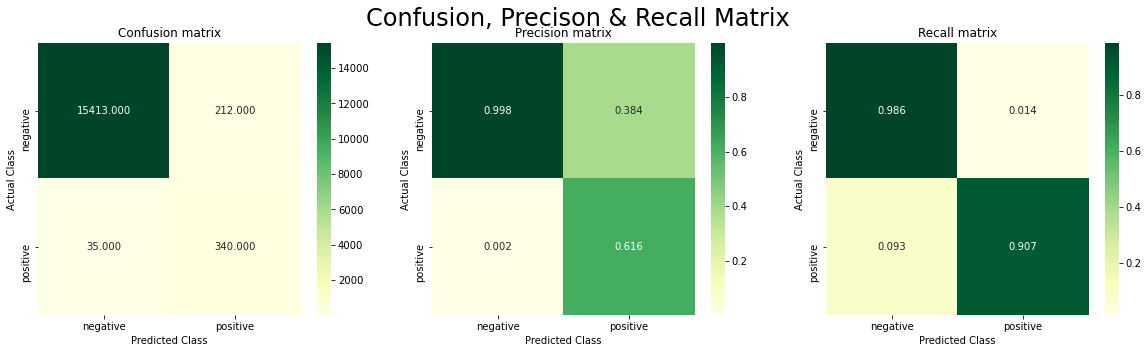

#False positives(Type 1 error) : 212
#False negatives(Type 2 error) : 35
cost : 19620
Selecting best threshold that gives lowest cost


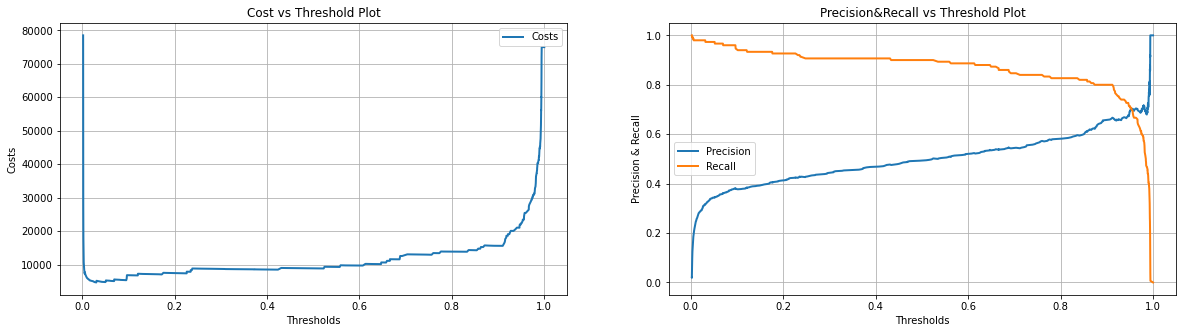

Best threshold: 0.0307
cost at this thresold: 4660.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9971 |  0.9703  |  0.9835  | 87310 |
|   CV  |  0.98  |  0.3175  |  0.4796  |  4660 |
|  test | 0.976  |  0.4067  |  0.5741  |  9840 |
+-------+--------+----------+----------+-------+


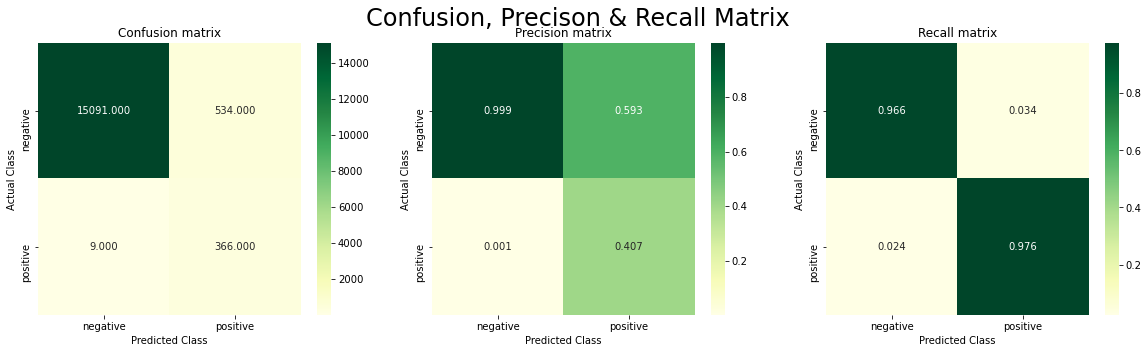

#False positives(Type 1 error) : 534
#False negatives(Type 2 error) : 9
cost : 9840


['ML models & Results/med_RF.pkl']

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med, y_train))
best_clf.fit(x_tr_med,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_RF.pkl')

### 5.2.5 XGBClassifier on Median Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 50.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 63.8min finished


Best parameters are:
 {'subsample': 0.3, 'n_estimators': 700, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.5}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9994616151545364

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0

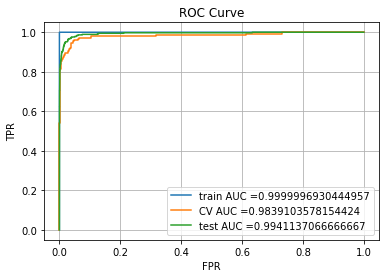

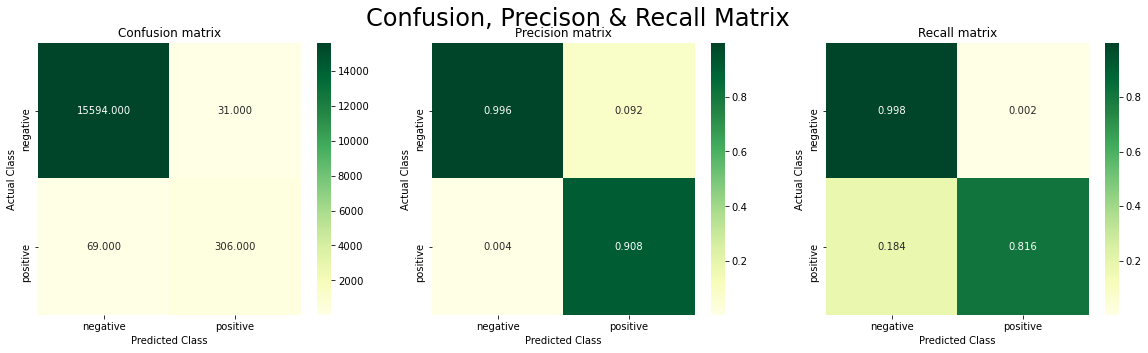

#False positives(Type 1 error) : 31
#False negatives(Type 2 error) : 69
cost : 34810
Selecting best threshold that gives lowest cost


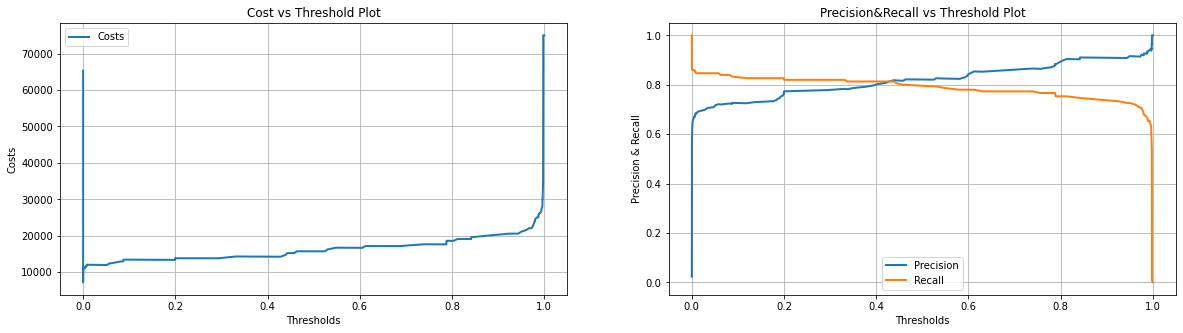

Best threshold: 0.0003
cost at this thresold: 7210.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9613  |  0.9803  | 20200 |
|   CV  |  0.96  |  0.2549  |  0.4028  |  7210 |
|  test | 0.976  |  0.3502  |  0.5155  | 11290 |
+-------+--------+----------+----------+-------+


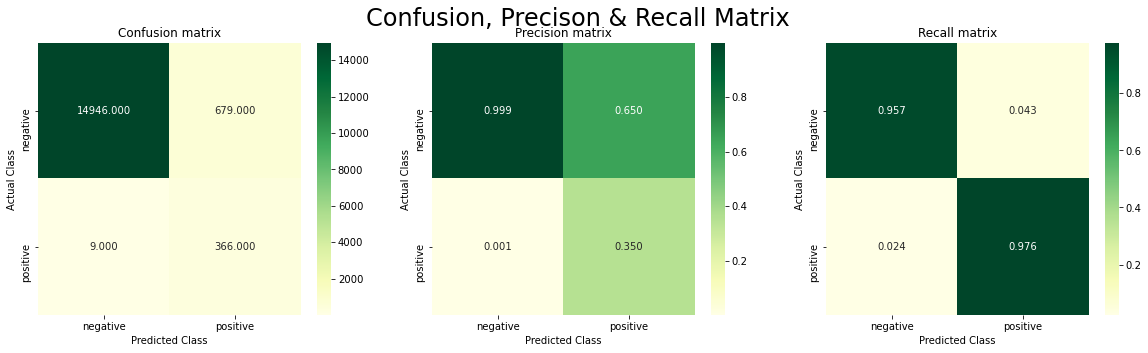

#False positives(Type 1 error) : 679
#False negatives(Type 2 error) : 9
cost : 11290


['ML models & Results/med_XGB.pkl']

In [17]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med, y_train))
best_clf.fit(x_tr_med,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_XGB.pkl')

### 5.2.6 AdaBoostClassifier on Median Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 58.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 67.4min finished


Best parameters are:
 {'n_estimators': 200, 'learning_rate': 0.75, 'algorithm': 'SAMME.R'}

Best estimator is:
 AdaBoostClassifier(learning_rate=0.75, n_estimators=200, random_state=42)

And it's best recall score is : 0.9858025922233299

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9893 |  0.9831  |  0.9862  | 276520 |
|   CV  | 0.8333 |  0.431   |  0.5682  | 14150  |
|  test | 0.9067 |  0.5519  |  0.6862  | 20260  |
+-------+--------+----------+----------+--------+


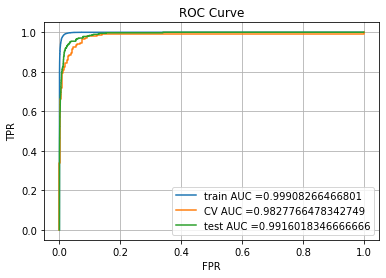

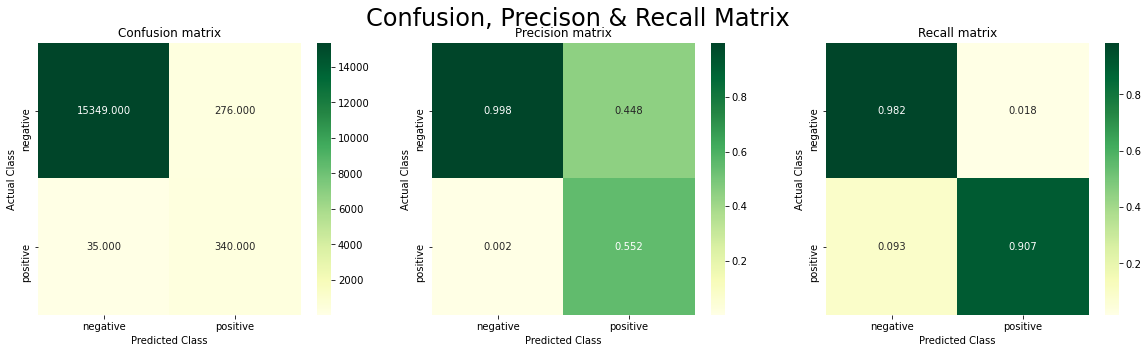

#False positives(Type 1 error) : 276
#False negatives(Type 2 error) : 35
cost : 20260
Selecting best threshold that gives lowest cost


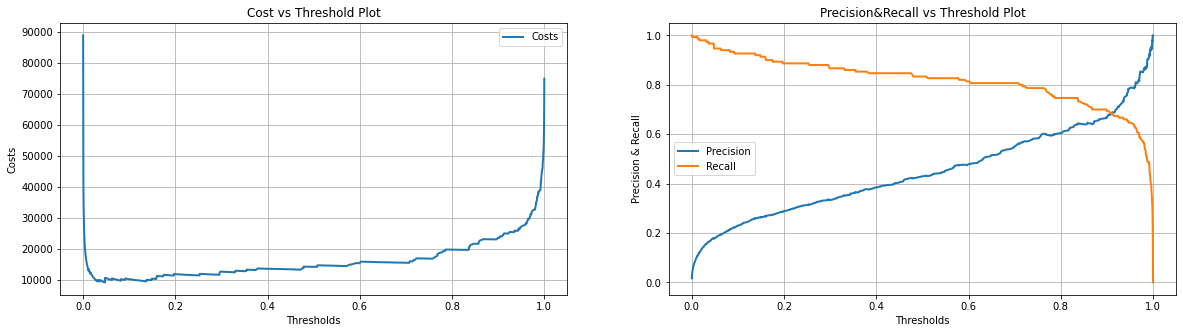

Best threshold: 0.0474
cost at this thresold: 9100.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9997 |  0.9301  |  0.9637  | 45150 |
|   CV  | 0.9667 |  0.1801  |  0.3037  |  9100 |
|  test | 0.9707 |  0.2376  |  0.3818  | 17180 |
+-------+--------+----------+----------+-------+


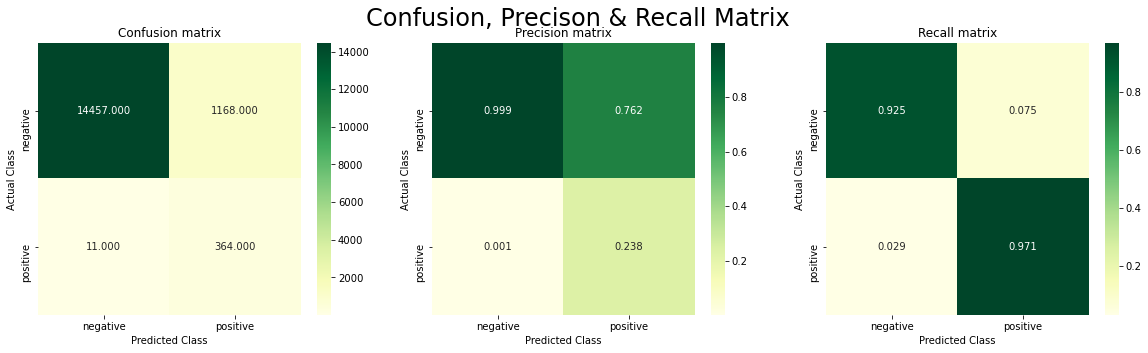

#False positives(Type 1 error) : 1168
#False negatives(Type 2 error) : 11
cost : 17180


['ML models & Results/med_AB.pkl']

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = AdaBoostClassifier(random_state=42)
params = {
    "n_estimators": [50, 75, 100,150,200,250,400,500],
    'learning_rate':[0.01,0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1],
    'algorithm' : ['SAMME', 'SAMME.R']    
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_med, y_train))
best_clf.fit(x_tr_med,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, best_clf.predict(x_te_med))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_med)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_med)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('AdaBoostClassifier','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_AB.pkl')

### 5.2.7 MetaLearnClassifier on Median Imputed Data

Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :
 [0.97926221 0.9890329  0.9884347  0.98988036 0.99167498 0.99137587
 0.98938185 0.99147557 0.98963111 0.99047856 0.98898305]


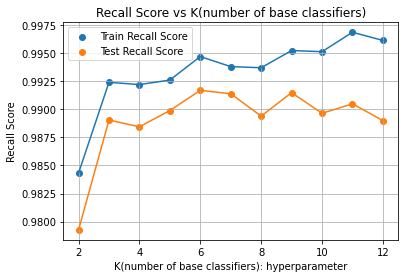

Best parameters:	 k =  6
And its best recall score is :  0.9916749750747756
So training 6 base learns and 1 metal learner on top of it.....

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9961 |  0.994   |  0.9951  | 101490 |
|   CV  |  0.76  |  0.5182  |  0.6162  | 19060  |
|  test | 0.7653 |  0.6421  |  0.6983  | 45600  |
+-------+--------+----------+----------+--------+


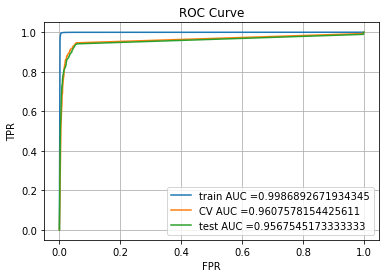

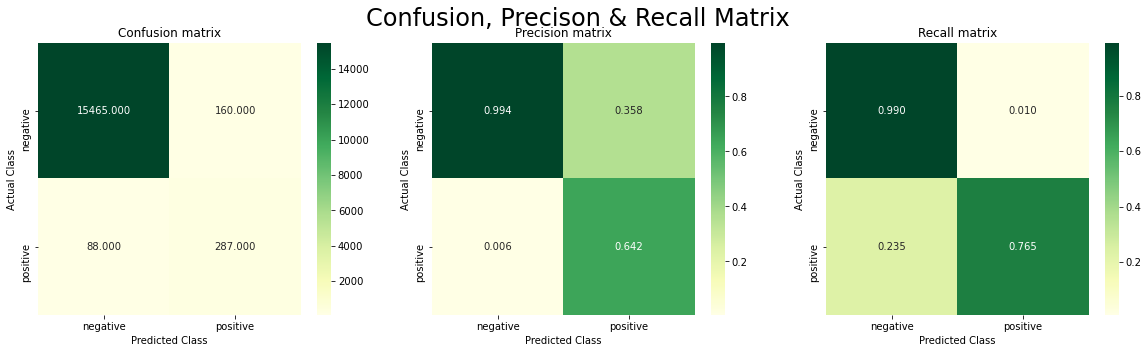

#False positives(Type 1 error) : 160
#False negatives(Type 2 error) : 88
cost : 45600
Selecting best threshold that gives lowest cost


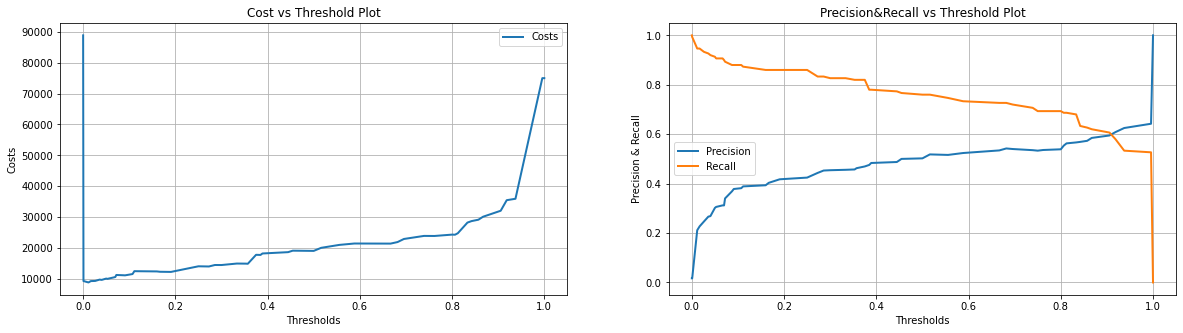

Best threshold: 0.0116
cost at this thresold: 8840.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9996 |  0.9589  |  0.9788  | 30990 |
|   CV  | 0.9467 |  0.2268  |  0.366   |  8840 |
|  test | 0.936  |  0.2997  |  0.4541  | 20200 |
+-------+--------+----------+----------+-------+


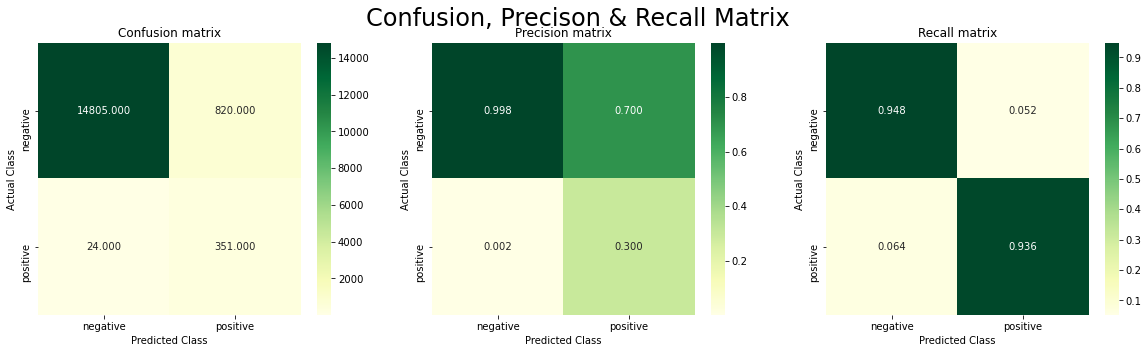

#False positives(Type 1 error) : 820
#False negatives(Type 2 error) : 24
cost : 20200


['ML models & Results/med_MLC.pkl']

In [27]:
#Hyperparameter tuning classifier with params
best_k, best_recall_score = hyperparameter_tuning_kflod_metaLearnClassifier(x_tr_med, y_train)
print("Best parameters:\t k = ", best_k)
print("And its best recall score is : ", best_recall_score)

print("So training {0} base learns and 1 metal learner on top of it.....".format(best_k))
best_clf = train_metaLearnClassifier(x_tr_med,y_train, best_k)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table_metaLearnClassifier(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_roc_curve_metaLearnClassifier(best_clf, [x_tr_med, x_cv_med, x_te_med])
plot_confusion_matrix(y_test, pred_y_metaLearnClassifier(x_te_med, best_clf))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,pred_y_metaLearnClassifier(x_cv_med, best_clf, prob = True)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table_metaLearnClassifier(best_clf, [x_tr_med, x_cv_med, x_te_med], threshold = best_threshold)
y_te_pred = pred_y_metaLearnClassifier(x_te_med, best_clf, prob = True)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('MetalearningClassifier','median', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/med_MLC.pkl')

## 5.3 KNNImputer Imputed Dataset

### 5.3.1 loading Train, CV & Test datasets & Upsampling train dataset

In [28]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_KNN = pd.read_csv('x_tr_KNN.csv')
x_cv_KNN = pd.read_csv('x_cv_KNN.csv')
x_te_KNN = pd.read_csv('x_te_KNN.csv')

print('Shapes of Train, CV & Test data of :')
print(x_tr_KNN.shape, x_cv_KNN.shape, x_te_KNN.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_KNN,y_train = SMOTE_upsmapling(x_tr_KNN, y_train)

Shapes of Train, CV & Test data of :
(51000, 170) (9000, 170) (16000, 170)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 170) (100300,)


### 5.3.2 LogisticRegression on KNNImputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   33.9s finished


Best parameters are:
 {'penalty': 'l2', 'C': 10000}

Best estimator is:
 LogisticRegression(C=10000, random_state=42)

And it's best recall score is : 0.9475573280159522

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8733 |  0.9886  |  0.9274  | 3181540 |
|   CV  |  0.8   |  0.553   |  0.654   |  15970  |
|  test | 0.8533 |  0.6612  |  0.7451  |  29140  |
+-------+--------+----------+----------+---------+


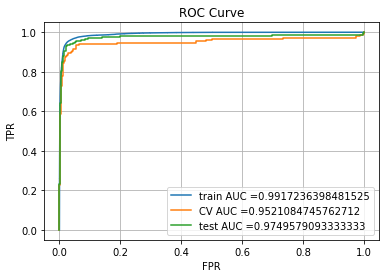

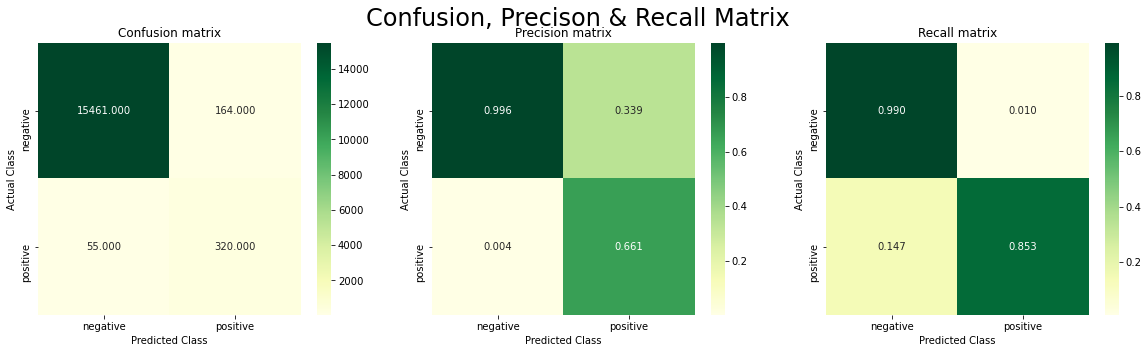

#False positives(Type 1 error) : 164
#False negatives(Type 2 error) : 55
cost : 29140
Selecting best threshold that gives lowest cost


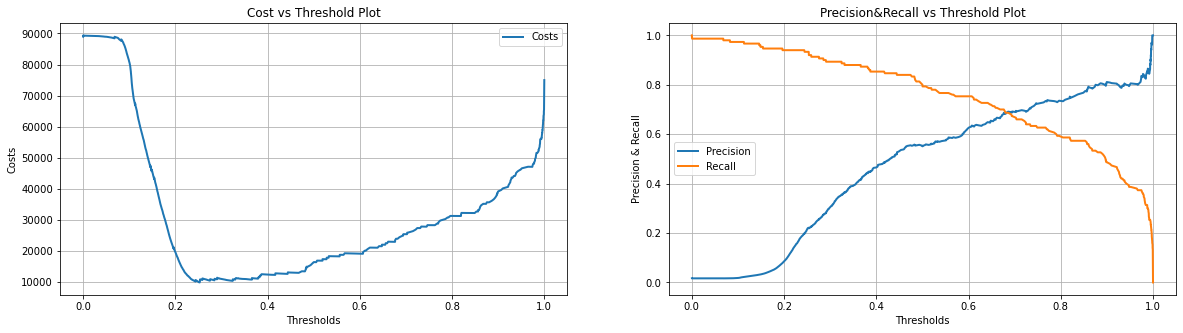

Best threshold: 0.2527
cost at this thresold: 9920.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9728 |  0.9453  |  0.9588  | 711230 |
|   CV  | 0.9333 |  0.2215  |  0.3581  |  9920  |
|  test | 0.9573 |  0.2916  |  0.4471  | 16720  |
+-------+--------+----------+----------+--------+


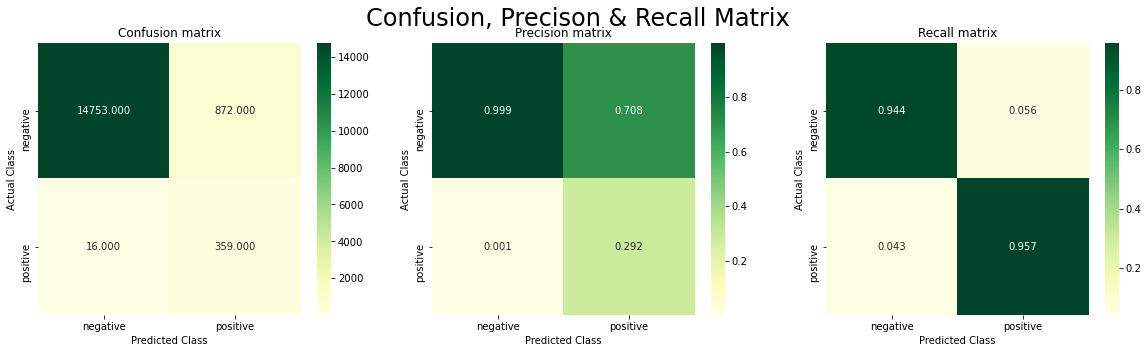

#False positives(Type 1 error) : 872
#False negatives(Type 2 error) : 16
cost : 16720


['ML models & Results/KNNimp_LR.pkl']

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN, y_train))
best_clf.fit(x_tr_KNN,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LogisticRegression','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_LR.pkl')

### 5.3.3 LinearSVC on KNNImputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.5min finished


Best parameters are:
 {'penalty': 'l2', 'C': 10}

Best estimator is:
 LinearSVC(C=10, random_state=42)

And it's best recall score is : 0.9496111665004985

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8444 |  0.9854  |  0.9094  | 3908780 |
|   CV  | 0.7733 |  0.4957  |  0.6042  |  18180  |
|  test | 0.856  |  0.6114  |  0.7133  |  29040  |
+-------+--------+----------+----------+---------+


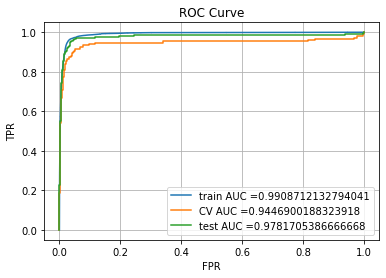

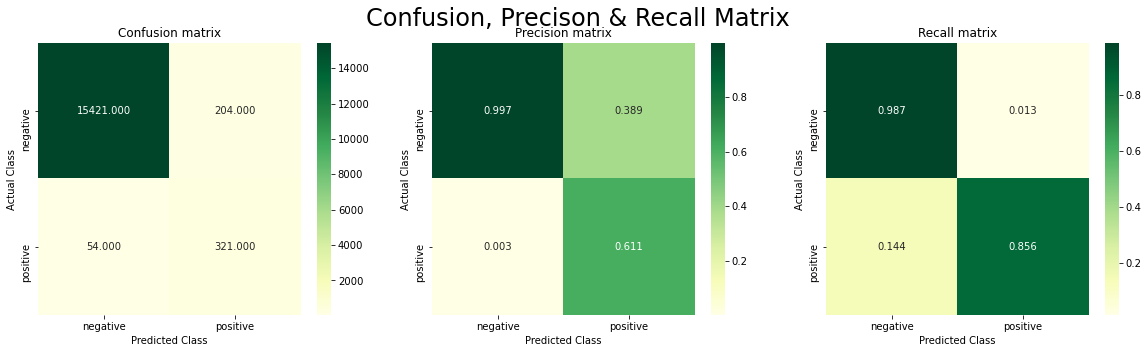

#False positives(Type 1 error) : 204
#False negatives(Type 2 error) : 54
cost : 29040
Selecting best threshold that gives lowest cost


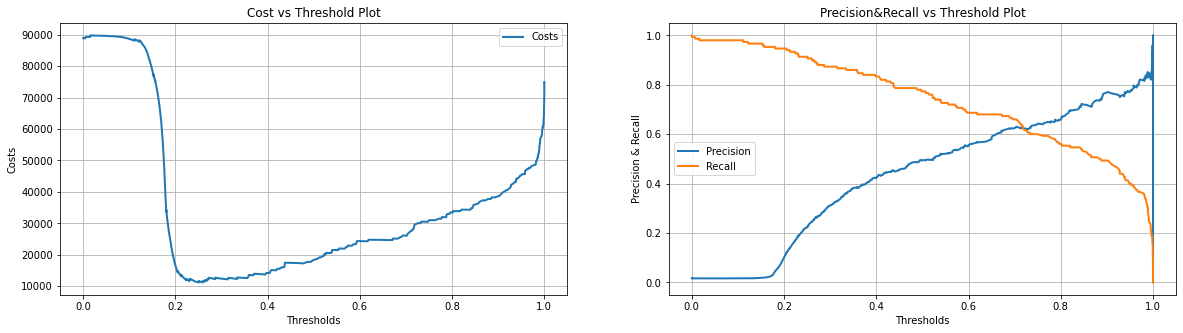

Best threshold: 0.2510
cost at this thresold: 11170.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9736 |   0.95   |  0.9617  | 687200 |
|   CV  | 0.9133 |  0.2268  |  0.3634  | 11170  |
|  test | 0.968  |  0.3198  |  0.4808  | 13720  |
+-------+--------+----------+----------+--------+


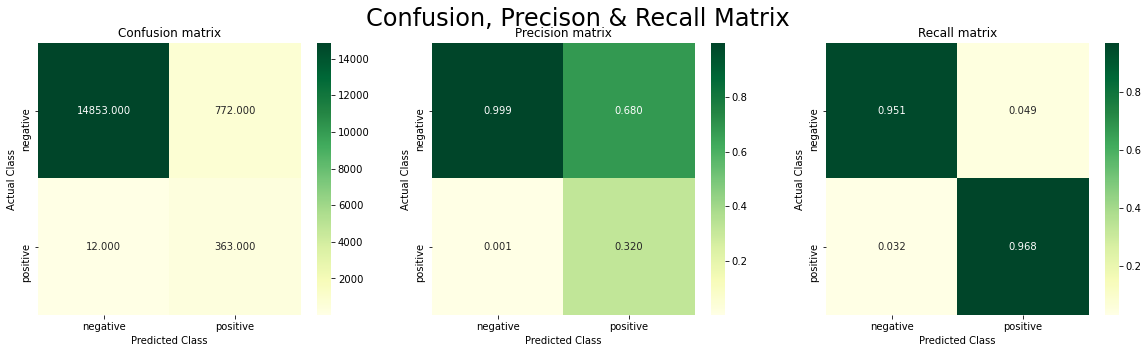

#False positives(Type 1 error) : 772
#False negatives(Type 2 error) : 12
cost : 13720


['ML models & Results/KNNimp_SVM.pkl']

In [30]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN, y_train))
best_clf.fit(x_tr_KNN,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LinearSVM','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_SVM.pkl')

### 5.3.4 RandomForestClassifier on KNNImputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 56.0min finished


Best parameters are:
 {'n_estimators': 400, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 11}

Best estimator is:
 RandomForestClassifier(max_depth=11, min_samples_leaf=3, min_samples_split=7,
                       n_estimators=400, random_state=42)

And it's best recall score is : 0.9936590229312063

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9933 |  0.9885  |  0.9909  | 173820 |
|   CV  | 0.8867 |  0.475   |  0.6186  |  9970  |
|  test | 0.8987 |  0.5975  |  0.7178  | 21270  |
+-------+--------+----------+----------+--------+


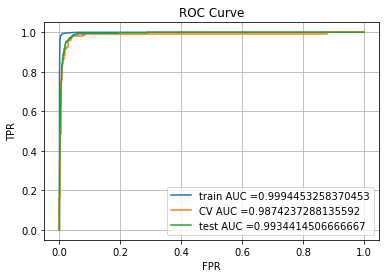

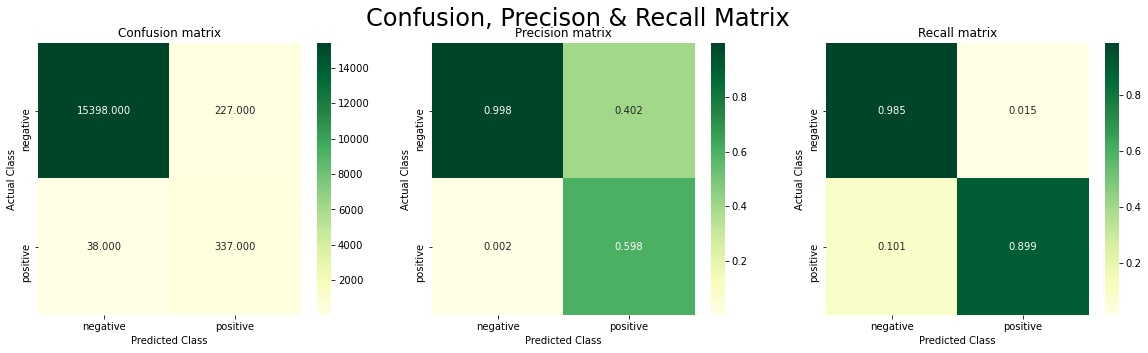

#False positives(Type 1 error) : 227
#False negatives(Type 2 error) : 38
cost : 21270
Selecting best threshold that gives lowest cost


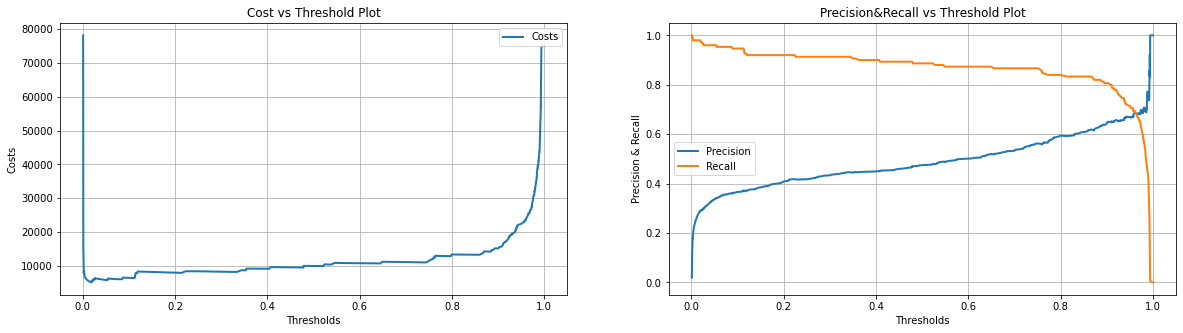

Best threshold: 0.0194
cost at this thresold: 5090.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9978 |  0.9655  |  0.9814  | 71870 |
|   CV  |  0.98  |  0.2905  |  0.4482  |  5090 |
|  test | 0.9787 |  0.3756  |  0.5429  | 10100 |
+-------+--------+----------+----------+-------+


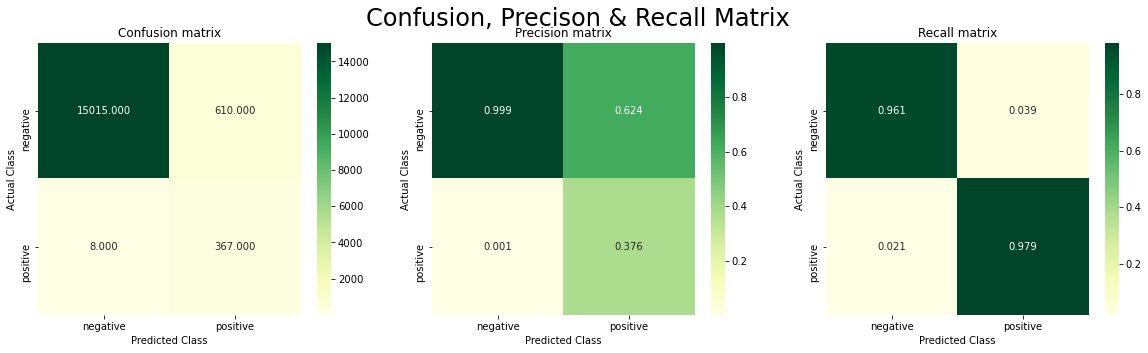

#False positives(Type 1 error) : 610
#False negatives(Type 2 error) : 8
cost : 10100


['ML models & Results/KNNimp_RF.pkl']

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN, y_train))
best_clf.fit(x_tr_KNN,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_RF.pkl')

### 5.3.5 XGBClassifier on KNNImputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 72.1min finished


Best parameters are:
 {'subsample': 0.3, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.3}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.999481555333998

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0   

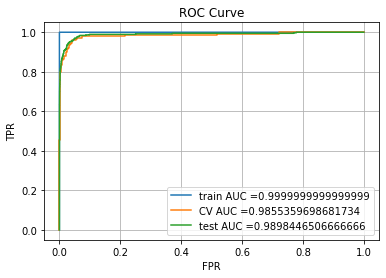

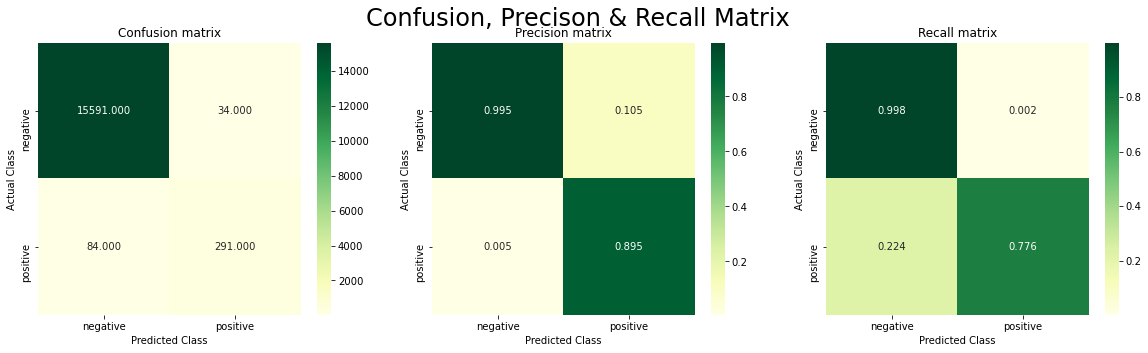

#False positives(Type 1 error) : 34
#False negatives(Type 2 error) : 84
cost : 42340
Selecting best threshold that gives lowest cost


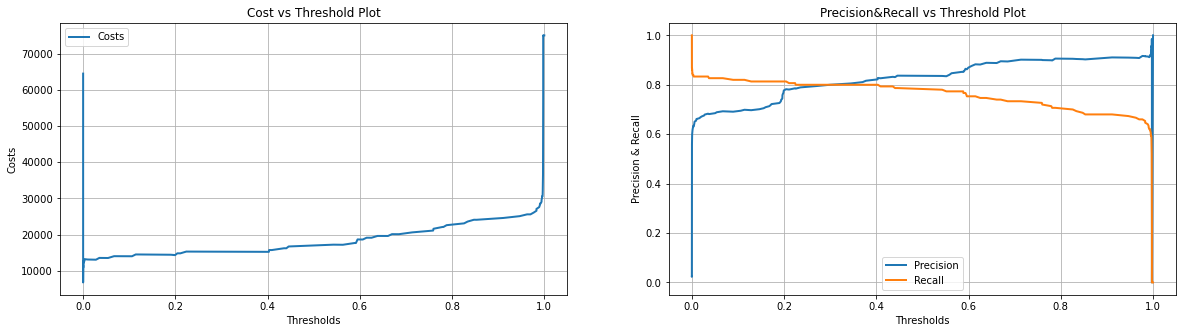

Best threshold: 0.0003
cost at this thresold: 6800.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9613  |  0.9803  | 20170 |
|   CV  |  0.96  |  0.2748  |  0.4273  |  6800 |
|  test | 0.9573 |  0.3475  |  0.5099  | 14740 |
+-------+--------+----------+----------+-------+


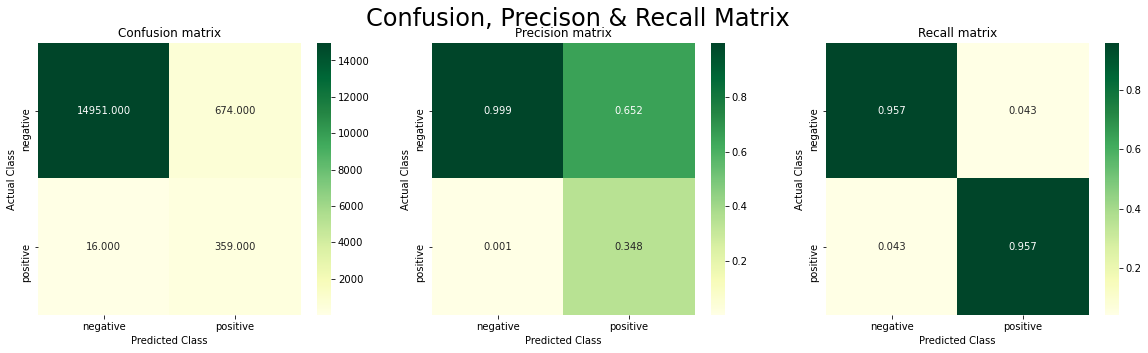

#False positives(Type 1 error) : 674
#False negatives(Type 2 error) : 16
cost : 14740


['ML models & Results/KNNimp_XGB.pkl']

In [32]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN, y_train))
best_clf.fit(x_tr_KNN,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_XGB.pkl')

### 5.3.6 AdaBoostClassifier on KNNImputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 109.1min finished


Best parameters are:
 {'n_estimators': 500, 'learning_rate': 0.75, 'algorithm': 'SAMME.R'}

Best estimator is:
 AdaBoostClassifier(learning_rate=0.75, n_estimators=500, random_state=42)

And it's best recall score is : 0.9940378863409769

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9979 |  0.9884  |  0.9931  | 59370 |
|   CV  | 0.8067 |  0.4783  |  0.6005  | 15820 |
|  test | 0.864  |  0.6148  |  0.7184  | 27530 |
+-------+--------+----------+----------+-------+


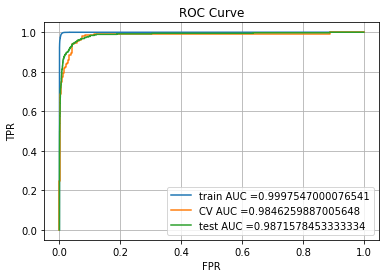

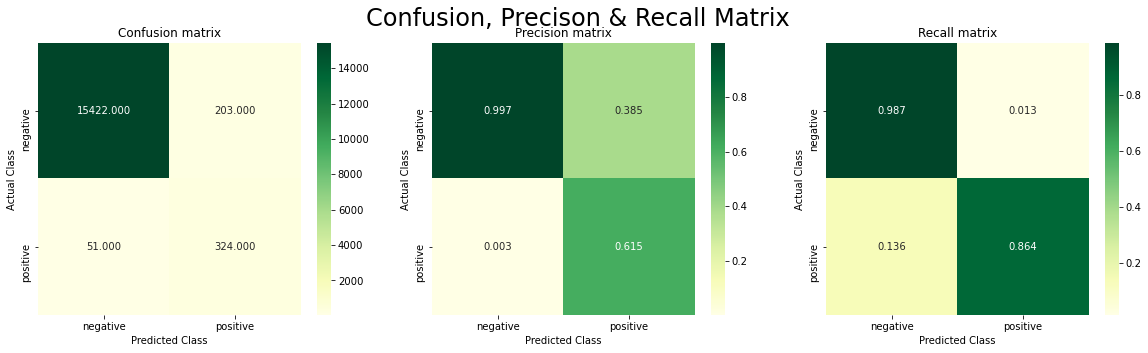

#False positives(Type 1 error) : 203
#False negatives(Type 2 error) : 51
cost : 27530
Selecting best threshold that gives lowest cost


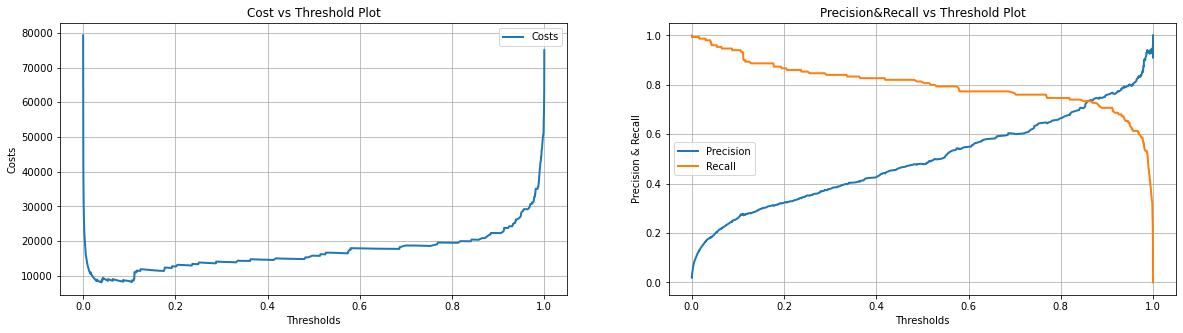

Best threshold: 0.0397
cost at this thresold: 8110.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9342  |  0.966   | 35350 |
|   CV  |  0.98  |  0.1819  |  0.3069  |  8110 |
|  test | 0.9627 |  0.2479  |  0.3943  | 17950 |
+-------+--------+----------+----------+-------+


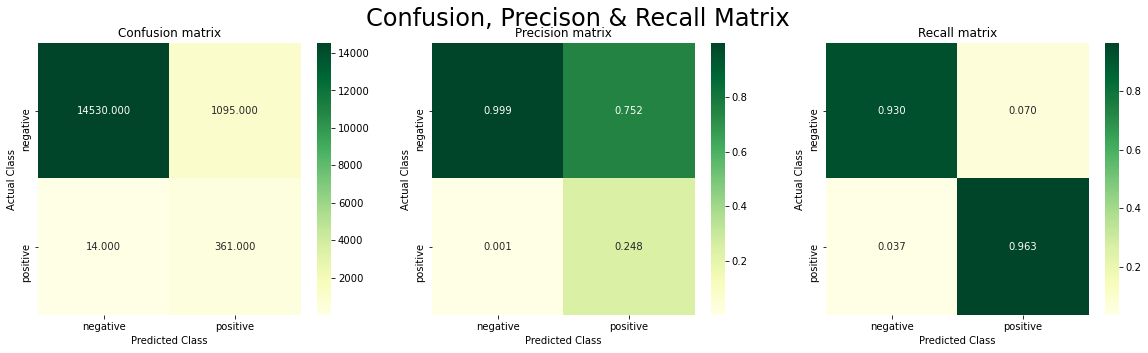

#False positives(Type 1 error) : 1095
#False negatives(Type 2 error) : 14
cost : 17950


['ML models & Results/KNNimp_AB.pkl']

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = AdaBoostClassifier(random_state=42)
params = {
    "n_estimators": [50, 75, 100,150,200,250,400,500],
    'learning_rate':[0.01,0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1],
    'algorithm' : ['SAMME', 'SAMME.R']    
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_KNN, y_train))
best_clf.fit(x_tr_KNN,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, best_clf.predict(x_te_KNN))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_KNN)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_KNN)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('AdaBoostClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_AB.pkl')

### 5.3.7 MetaLearnClassifier on KNNImputer Imputed Data

Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :
 [0.96460618 0.98908275 0.98728814 0.98938185 0.99057827 0.99097707
 0.99097707 0.9888335  0.9894317  0.98993021 0.98773679]


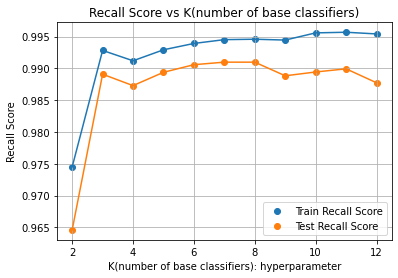

Best parameters:	 k =  7
And its best recall score is :  0.9909770687936191
So training 7 base learns and 1 metal learner on top of it.....

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9972 |  0.9941  |  0.9957  | 72460 |
|   CV  |  0.76  |  0.477   |  0.5861  | 19250 |
|  test | 0.7227 |  0.5693  |  0.6369  | 54050 |
+-------+--------+----------+----------+-------+


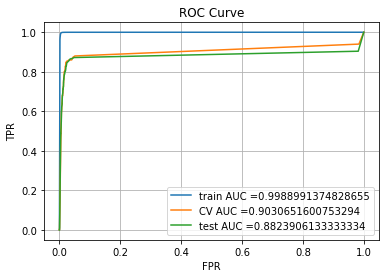

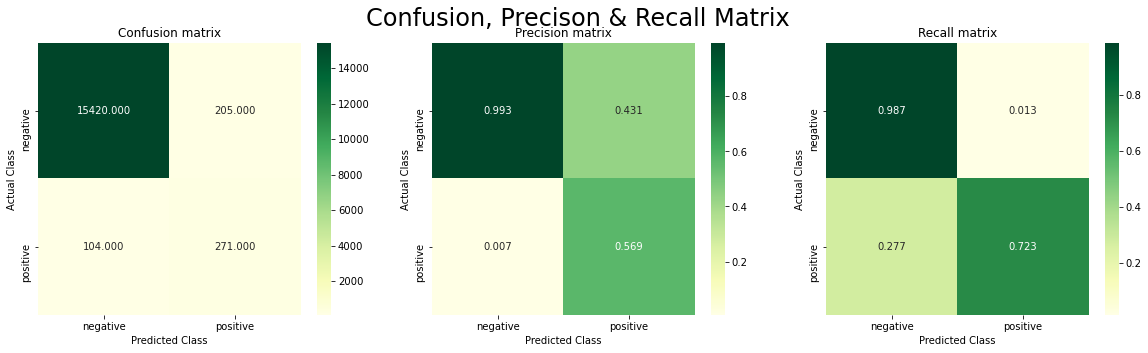

#False positives(Type 1 error) : 205
#False negatives(Type 2 error) : 104
cost : 54050
Selecting best threshold that gives lowest cost


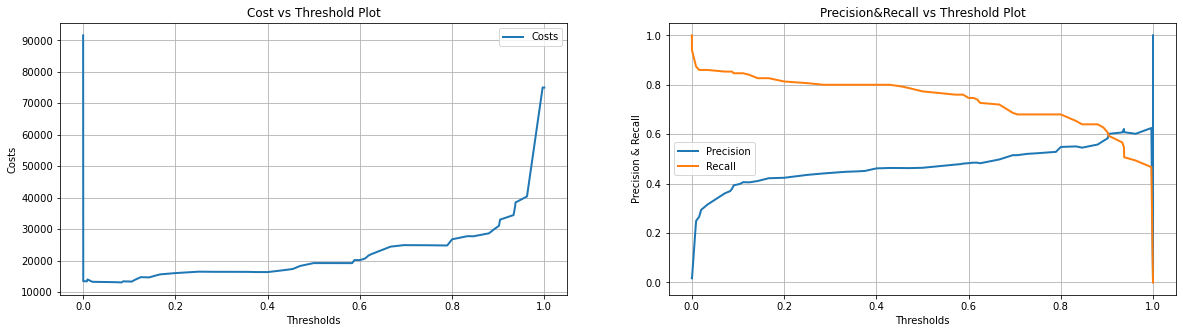

Best threshold: 0.0833
cost at this thresold: 13100.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9996 |  0.9859  |  0.9927  | 18170 |
|   CV  | 0.8533 |  0.3787  |  0.5246  | 13100 |
|  test | 0.832  |  0.465   |  0.5966  | 35090 |
+-------+--------+----------+----------+-------+


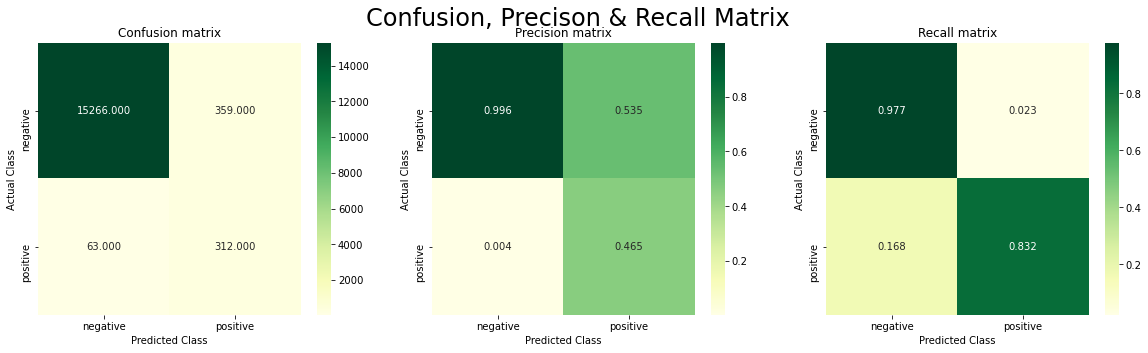

#False positives(Type 1 error) : 359
#False negatives(Type 2 error) : 63
cost : 35090


['ML models & Results/KNNimp_MLC.pkl']

In [34]:
#Hyperparameter tuning classifier with params
best_k, best_recall_score = hyperparameter_tuning_kflod_metaLearnClassifier(x_tr_KNN, y_train)
print("Best parameters:\t k = ", best_k)
print("And its best recall score is : ", best_recall_score)

print("So training {0} base learns and 1 metal learner on top of it.....".format(best_k))
best_clf = train_metaLearnClassifier(x_tr_KNN,y_train, best_k)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table_metaLearnClassifier(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_roc_curve_metaLearnClassifier(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN])
plot_confusion_matrix(y_test, pred_y_metaLearnClassifier(x_te_KNN, best_clf))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,pred_y_metaLearnClassifier(x_cv_KNN, best_clf, prob = True)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table_metaLearnClassifier(best_clf, [x_tr_KNN, x_cv_KNN, x_te_KNN], threshold = best_threshold)
y_te_pred = pred_y_metaLearnClassifier(x_te_KNN, best_clf, prob = True)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('MetalearningClassifier','KNNimputer', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/KNNimp_MLC.pkl')

## 5.4 BayesianRidge_imputer Imputed Dataset

### 5.4.1 loading Train, CV & Test datasets & Upsampling train dataset

In [35]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_BR = pd.read_csv('x_tr_BR.csv')
x_cv_BR = pd.read_csv('x_cv_BR.csv')
x_te_BR = pd.read_csv('x_te_BR.csv')

print('Shapes of Train, CV & Test data of :')
print(x_tr_BR.shape, x_cv_BR.shape, x_te_BR.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_BR,y_train = SMOTE_upsmapling(x_tr_BR, y_train)

Shapes of Train, CV & Test data of :
(51000, 170) (9000, 170) (16000, 170)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 170) (100300,)


### 5.4.2 LogisticRegression on BayesianRidge_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   32.2s finished


Best parameters are:
 {'penalty': 'l2', 'C': 10}

Best estimator is:
 LogisticRegression(C=10, random_state=42)

And it's best recall score is : 0.9498504486540378

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8551 |  0.9903  |  0.9177  | 3637710 |
|   CV  |  0.76  |  0.5644  |  0.6477  |  18880  |
|  test | 0.8053 |  0.6726  |  0.733   |  37970  |
+-------+--------+----------+----------+---------+


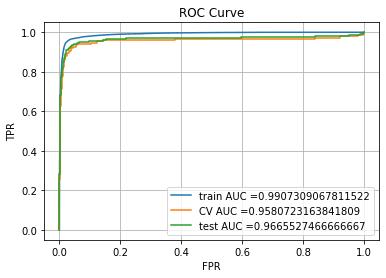

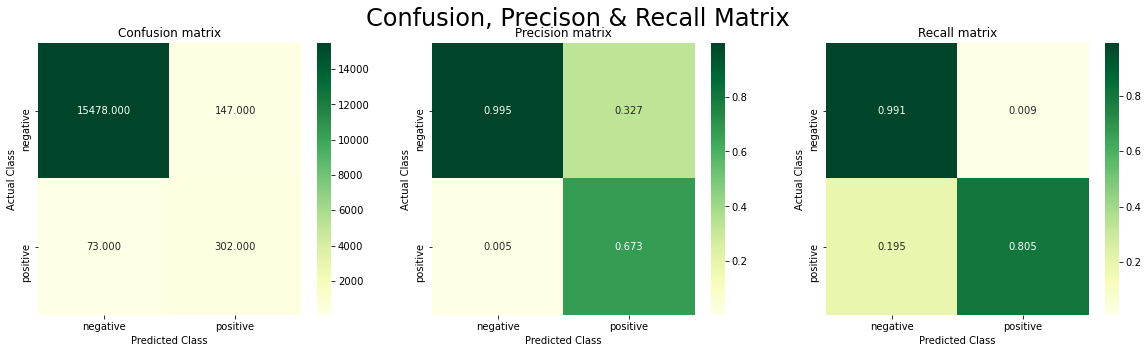

#False positives(Type 1 error) : 147
#False negatives(Type 2 error) : 73
cost : 37970
Selecting best threshold that gives lowest cost


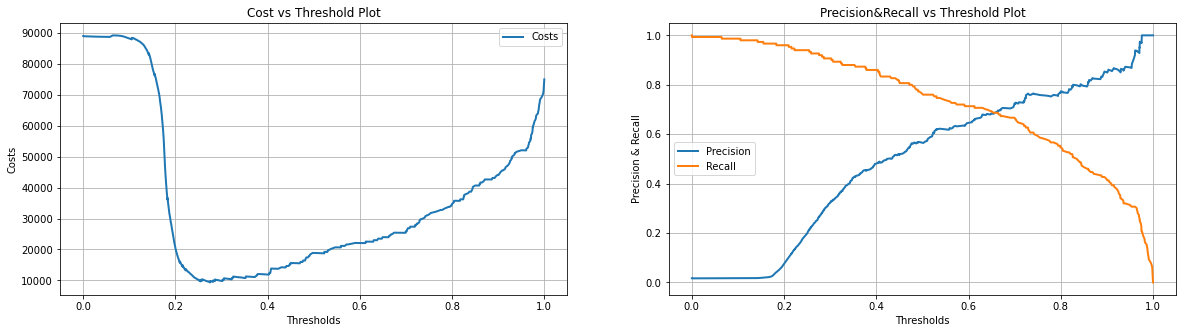

Best threshold: 0.2753
cost at this thresold: 9330.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9672 |  0.9569  |  0.962   | 843840 |
|   CV  | 0.9267 |  0.2663  |  0.4137  |  9330  |
|  test | 0.936  |  0.3472  |  0.5065  | 18600  |
+-------+--------+----------+----------+--------+


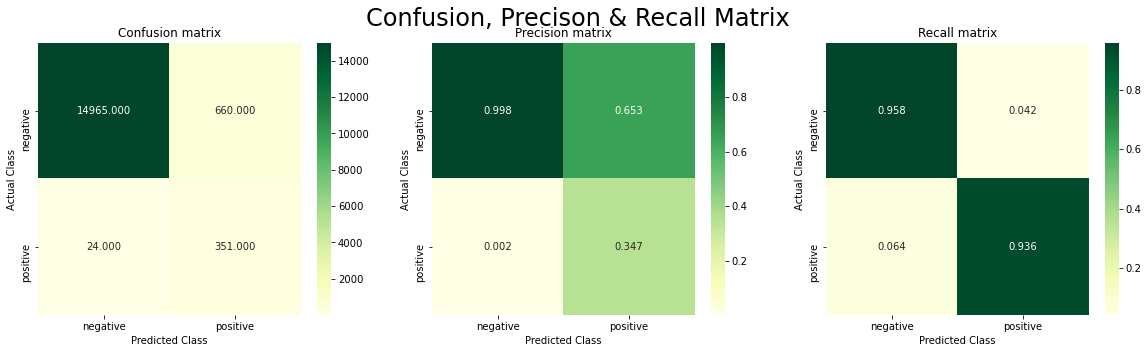

#False positives(Type 1 error) : 660
#False negatives(Type 2 error) : 24
cost : 18600


['ML models & Results/BRitimp_LR.pkl']

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR, y_train))
best_clf.fit(x_tr_BR,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LogisticRegression','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_LR.pkl')

### 5.4.3 LinearSVC on BayesianRidge_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.6min finished


Best parameters are:
 {'penalty': 'l2', 'C': 0.1}

Best estimator is:
 LinearSVC(C=0.1, random_state=42)

And it's best recall score is : 0.9463609172482552

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8666 |  0.9897  |  0.9241  | 3349020 |
|   CV  | 0.7667 |  0.5502  |  0.6407  |  18440  |
|  test | 0.8267 |  0.6554  |  0.7311  |  34130  |
+-------+--------+----------+----------+---------+


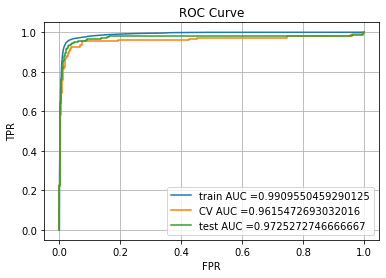

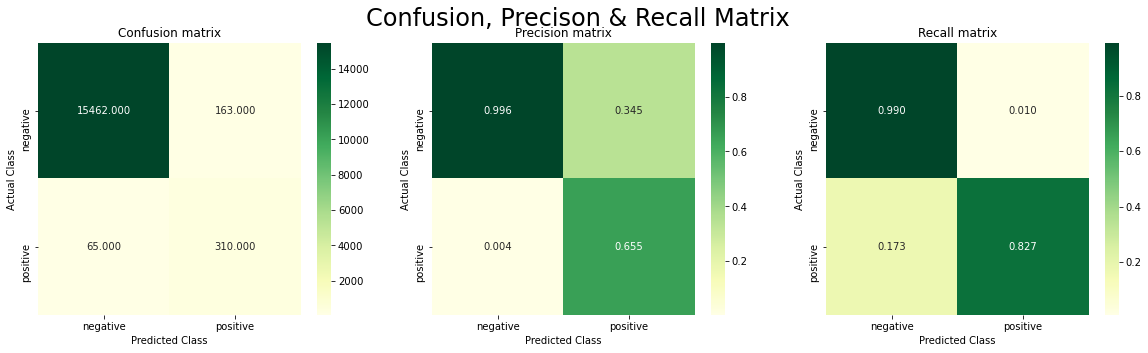

#False positives(Type 1 error) : 163
#False negatives(Type 2 error) : 65
cost : 34130
Selecting best threshold that gives lowest cost


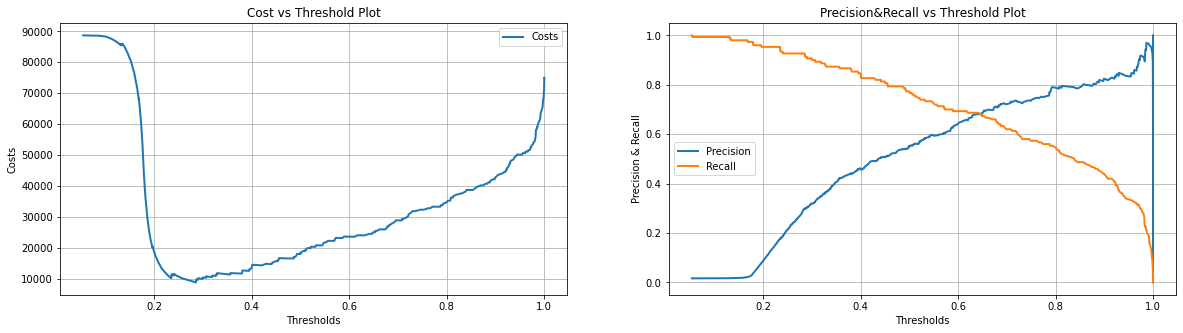

Best threshold: 0.2850
cost at this thresold: 8760.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9634 |  0.9618  |  0.9626  | 936210 |
|   CV  | 0.9267 |  0.2989  |  0.452   |  8760  |
|  test | 0.9333 |  0.3755  |  0.5356  | 18320  |
+-------+--------+----------+----------+--------+


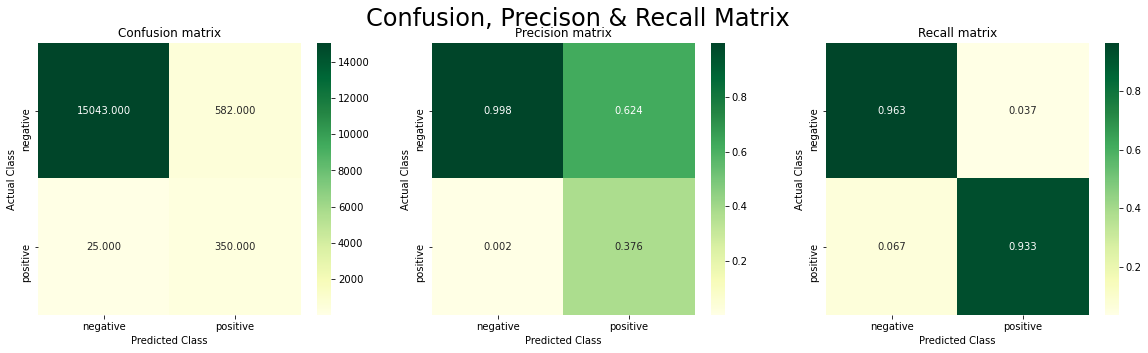

#False positives(Type 1 error) : 582
#False negatives(Type 2 error) : 25
cost : 18320


['ML models & Results/BRitimp_SVM.pkl']

In [37]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR, y_train))
best_clf.fit(x_tr_BR,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LinearSVM','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_SVM.pkl')

### 5.4.4 RandomForestClassifier on BayesianRidge_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 46.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 52.7min finished


Best parameters are:
 {'n_estimators': 600, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=5, min_samples_split=7,
                       n_estimators=600, random_state=42)

And it's best recall score is : 0.9932801595214358

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9929 |  0.9903  |  0.9916  | 183400 |
|   CV  |  0.88  |  0.5259  |  0.6584  | 10190  |
|  test | 0.8933 |  0.6333  |  0.7412  | 21940  |
+-------+--------+----------+----------+--------+


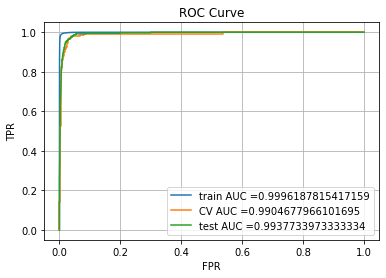

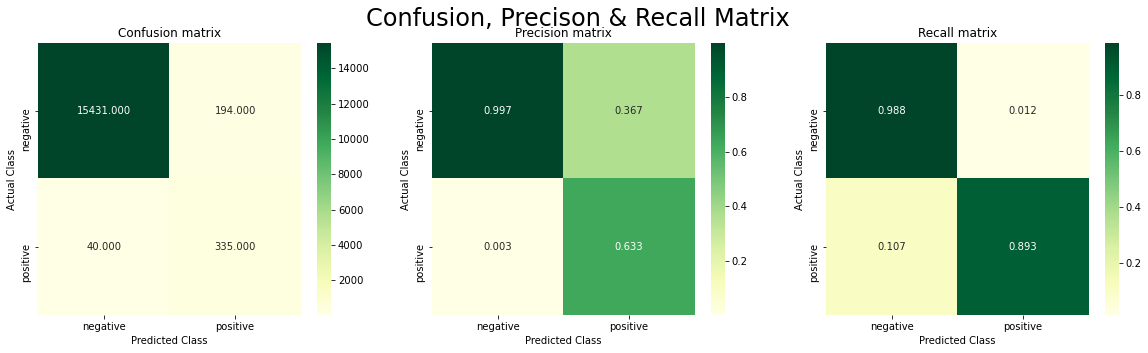

#False positives(Type 1 error) : 194
#False negatives(Type 2 error) : 40
cost : 21940
Selecting best threshold that gives lowest cost


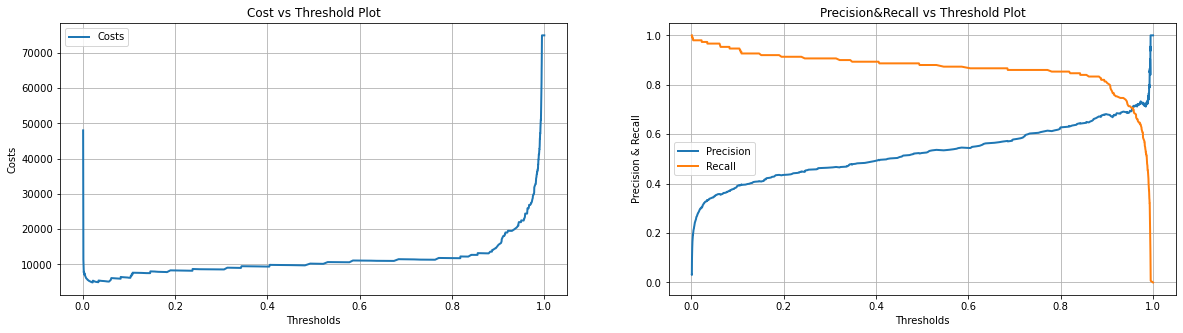

Best threshold: 0.0218
cost at this thresold: 4860.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9985 |  0.9683  |  0.9832  | 52890 |
|   CV  |  0.98  |  0.3043  |  0.4645  |  4860 |
|  test | 0.9707 |  0.3931  |  0.5596  | 11120 |
+-------+--------+----------+----------+-------+


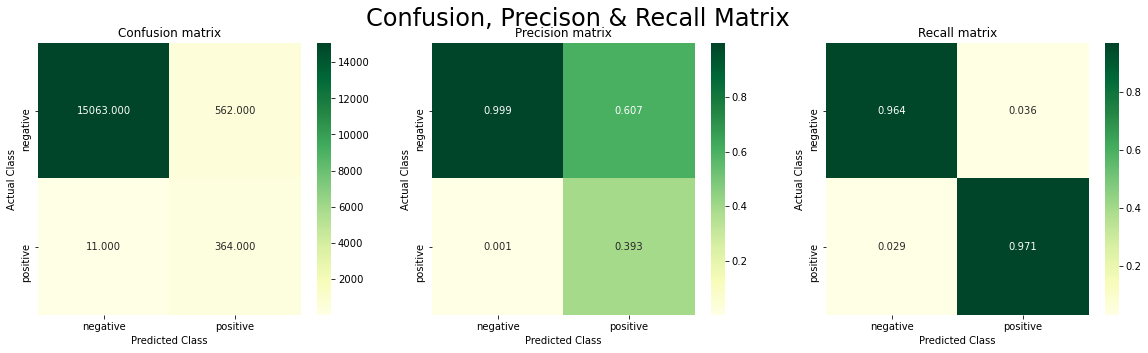

#False positives(Type 1 error) : 562
#False negatives(Type 2 error) : 11
cost : 11120


['ML models & Results/BRitimp_RF.pkl']

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR, y_train))
best_clf.fit(x_tr_BR,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_RF.pkl')

### 5.4.5 XGBClassifier on BayesianRidge_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 88.5min finished


Best parameters are:
 {'subsample': 0.3, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.1}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9995413758723828

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |   1.0  

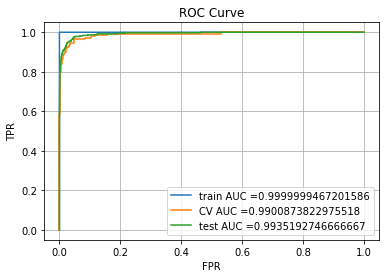

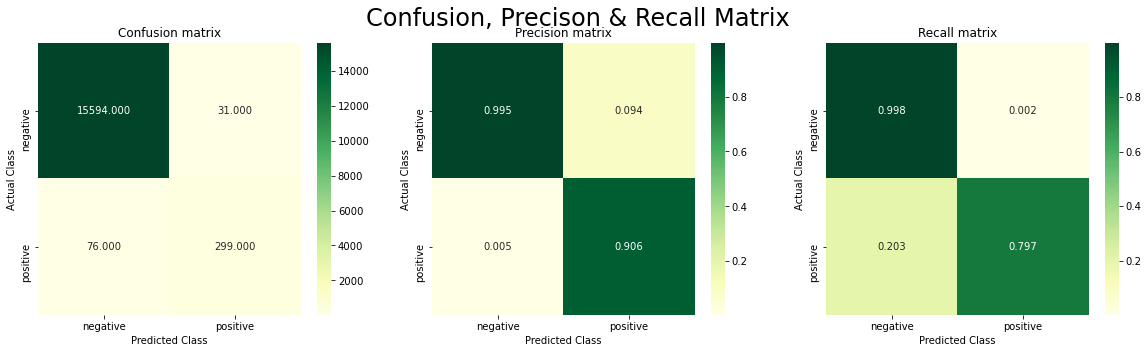

#False positives(Type 1 error) : 31
#False negatives(Type 2 error) : 76
cost : 38310
Selecting best threshold that gives lowest cost


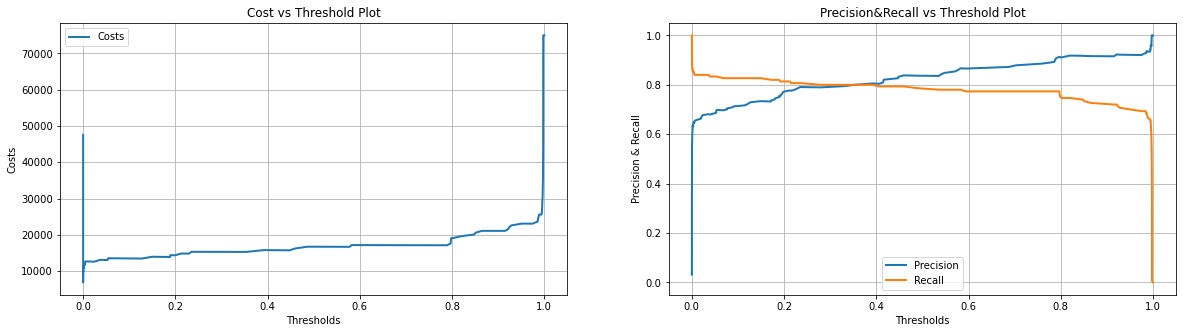

Best threshold: 0.0003
cost at this thresold: 6870.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9582  |  0.9786  | 21890 |
|   CV  | 0.9667 |  0.2491  |  0.3962  |  6870 |
|  test | 0.976  |  0.3339  |  0.4976  | 11800 |
+-------+--------+----------+----------+-------+


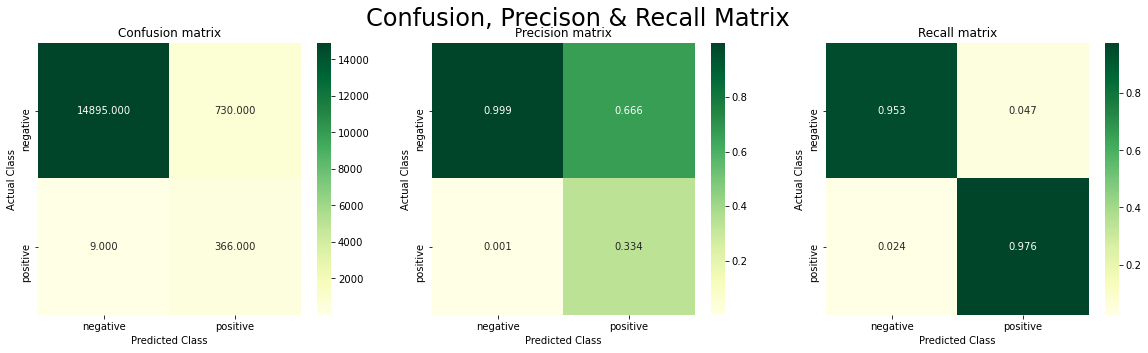

#False positives(Type 1 error) : 730
#False negatives(Type 2 error) : 9
cost : 11800


['ML models & Results/BRitimp_XGB.pkl']

In [39]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR, y_train))
best_clf.fit(x_tr_BR,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_XGB.pkl')

### 5.4.6 AdaBoostClassifier on BayesianRidge_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 68.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 91.5min finished


Best parameters are:
 {'n_estimators': 500, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

Best estimator is:
 AdaBoostClassifier(learning_rate=1, n_estimators=500, random_state=42)

And it's best recall score is : 0.9958923230309074

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9978 |  0.9947  |  0.9962  | 56690 |
|   CV  | 0.7933 |  0.5891  |  0.6761  | 16330 |
|  test | 0.8613 |  0.7007  |  0.7727  | 27380 |
+-------+--------+----------+----------+-------+


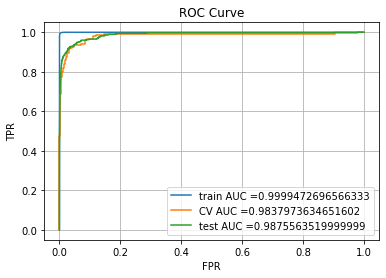

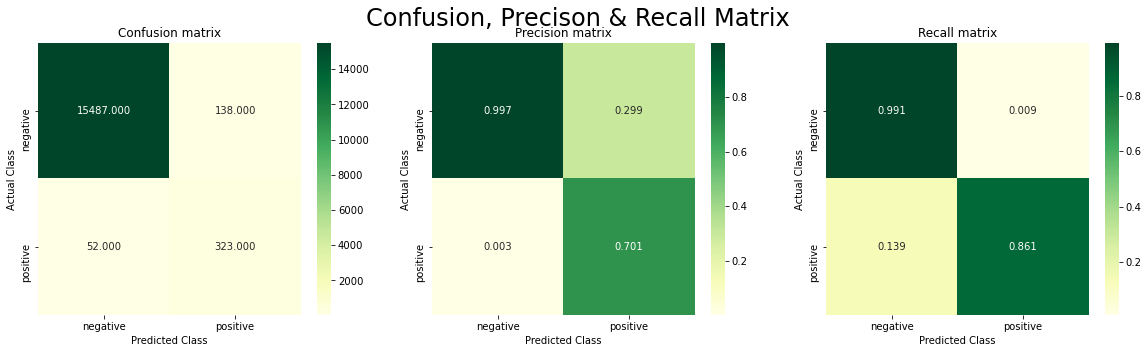

#False positives(Type 1 error) : 138
#False negatives(Type 2 error) : 52
cost : 27380
Selecting best threshold that gives lowest cost


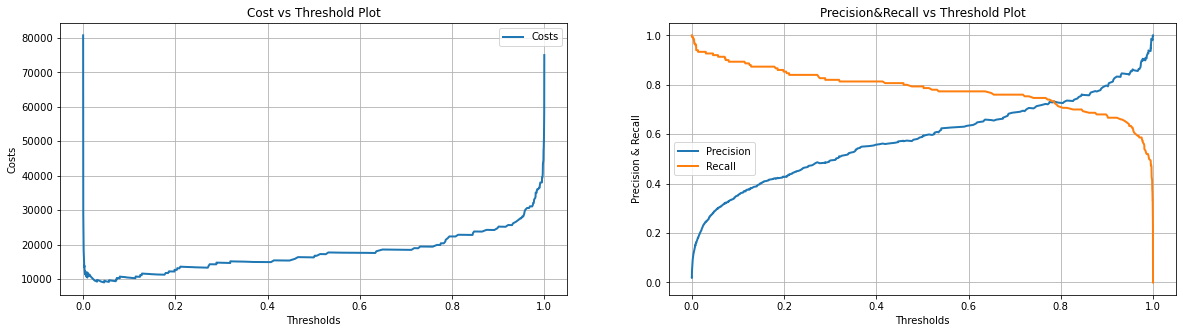

Best threshold: 0.0457
cost at this thresold: 9050.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9999 |  0.9639  |  0.9816  | 20300 |
|   CV  | 0.9267 |  0.2814  |  0.4317  |  9050 |
|  test | 0.928  |  0.3652  |  0.5241  | 19550 |
+-------+--------+----------+----------+-------+


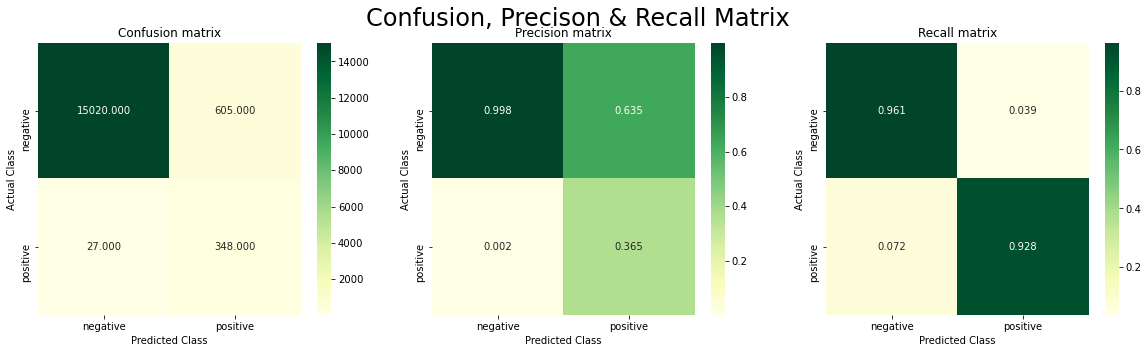

#False positives(Type 1 error) : 605
#False negatives(Type 2 error) : 27
cost : 19550


['ML models & Results/BRitimp_AB.pkl']

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = AdaBoostClassifier(random_state=42)
params = {
    "n_estimators": [50, 75, 100,150,200,250,400,500],
    'learning_rate':[0.01,0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1],
    'algorithm' : ['SAMME', 'SAMME.R']    
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BR, y_train))
best_clf.fit(x_tr_BR,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BR))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BR)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BR)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('AdaBoostClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_AB.pkl')

### 5.4.7 MetaLearnClassifier on BayesianRidge_imputer Imputed Data

Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :
 [0.96415753 0.99272183 0.98788634 0.99162512 0.98958126 0.99097707
 0.98963111 0.99182453 0.99022931 0.99192423 0.99222333]


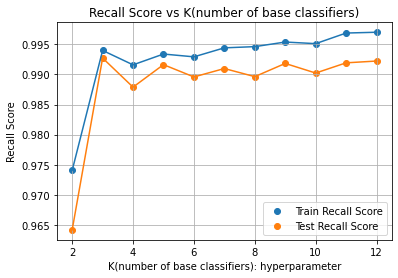

Best parameters:	 k =  3
And its best recall score is :  0.9927218344965104
So training 3 base learns and 1 metal learner on top of it.....

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.996  |  0.9914  |  0.9937  | 103820 |
|   CV  | 0.7733 |  0.4444  |  0.5645  | 18450  |
|  test | 0.776  |  0.5673  |  0.6554  | 44220  |
+-------+--------+----------+----------+--------+


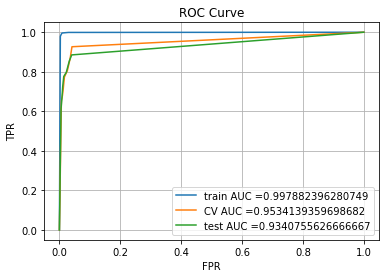

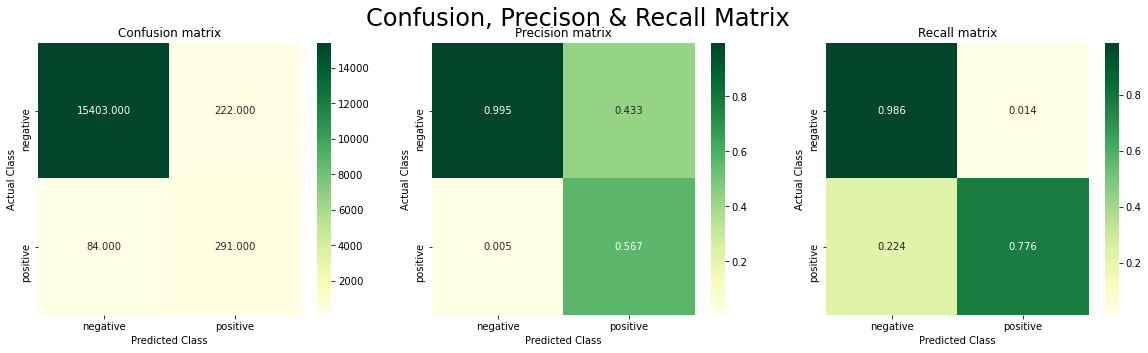

#False positives(Type 1 error) : 222
#False negatives(Type 2 error) : 84
cost : 44220
Selecting best threshold that gives lowest cost


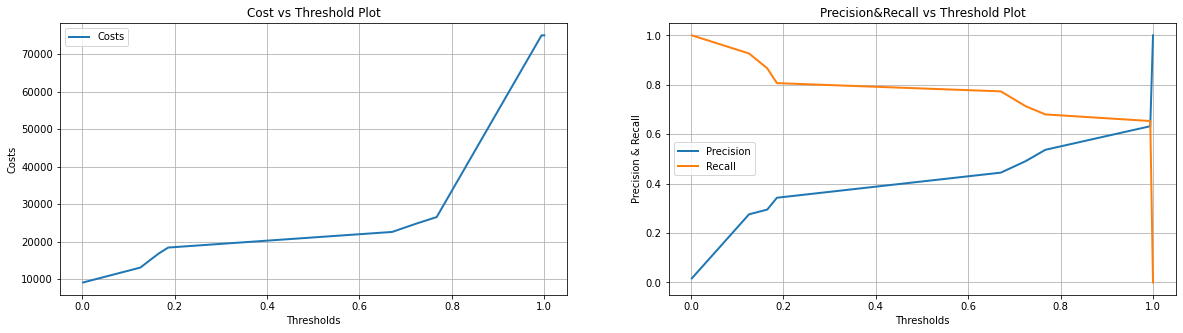

Best threshold: 0.0019
cost at this thresold: 9150.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9991 |  0.9706  |  0.9846  | 38690 |
|   CV  | 0.9267 |  0.2758  |  0.4251  |  9150 |
|  test | 0.8853 |  0.3451  |  0.4966  | 27800 |
+-------+--------+----------+----------+-------+


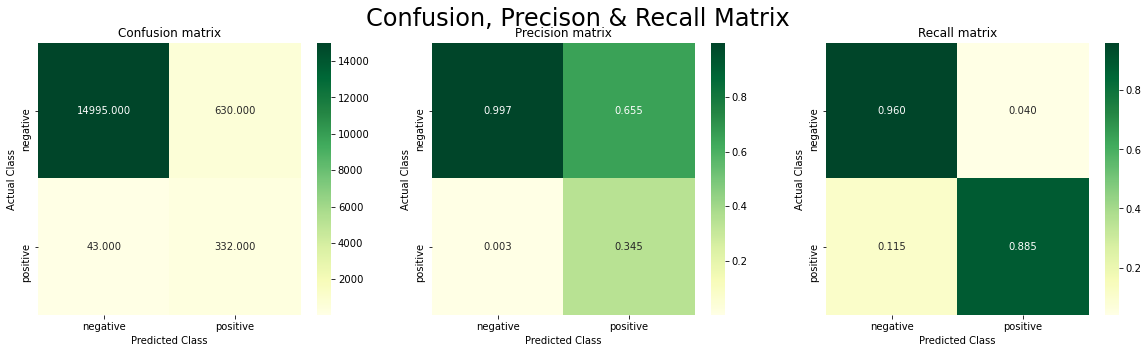

#False positives(Type 1 error) : 630
#False negatives(Type 2 error) : 43
cost : 27800


['ML models & Results/BRitimp_MLC.pkl']

In [41]:
#Hyperparameter tuning classifier with params
best_k, best_recall_score = hyperparameter_tuning_kflod_metaLearnClassifier(x_tr_BR, y_train)
print("Best parameters:\t k = ", best_k)
print("And its best recall score is : ", best_recall_score)

print("So training {0} base learns and 1 metal learner on top of it.....".format(best_k))
best_clf = train_metaLearnClassifier(x_tr_BR,y_train, best_k)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table_metaLearnClassifier(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_roc_curve_metaLearnClassifier(best_clf, [x_tr_BR, x_cv_BR, x_te_BR])
plot_confusion_matrix(y_test, pred_y_metaLearnClassifier(x_te_BR, best_clf))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,pred_y_metaLearnClassifier(x_cv_BR, best_clf, prob = True)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table_metaLearnClassifier(best_clf, [x_tr_BR, x_cv_BR, x_te_BR], threshold = best_threshold)
y_te_pred = pred_y_metaLearnClassifier(x_te_BR, best_clf, prob = True)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('MetalearningClassifier','BayesianRidgeRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BRitimp_MLC.pkl')

## 5.5 RandomForestRegressor_imputer Imputed Dataset

### 5.5.1 loading Train, CV & Test datasets & Upsampling train dataset

In [42]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_RF = pd.read_csv('x_tr_RF.csv')
x_cv_RF = pd.read_csv('x_cv_RF.csv')
x_te_RF = pd.read_csv('x_te_RF.csv')

print('Shapes of Train, CV & Test data of :')
print(x_tr_RF.shape, x_cv_RF.shape, x_te_RF.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_RF,y_train = SMOTE_upsmapling(x_tr_RF, y_train)

Shapes of Train, CV & Test data of :
(51000, 170) (9000, 170) (16000, 170)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 170) (100300,)


### 5.5.2 LogisticRegression on RandomForestRegressor_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   33.9s finished


Best parameters are:
 {'penalty': 'l2', 'C': 10000}

Best estimator is:
 LogisticRegression(C=10000, random_state=42)

And it's best recall score is : 0.953998005982054

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8201 |  0.9922  |  0.898   | 4515230 |
|   CV  |  0.76  |  0.6404  |  0.6951  |  18640  |
|  test | 0.7893 |  0.7167  |  0.7513  |  40670  |
+-------+--------+----------+----------+---------+


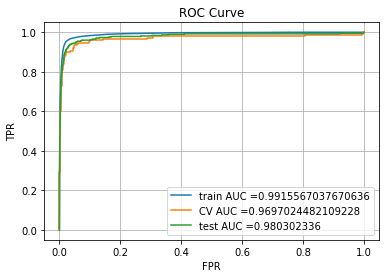

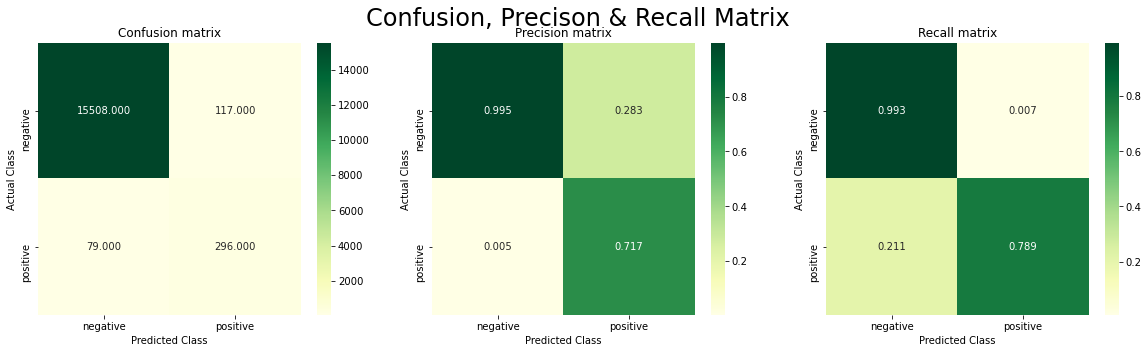

#False positives(Type 1 error) : 117
#False negatives(Type 2 error) : 79
cost : 40670
Selecting best threshold that gives lowest cost


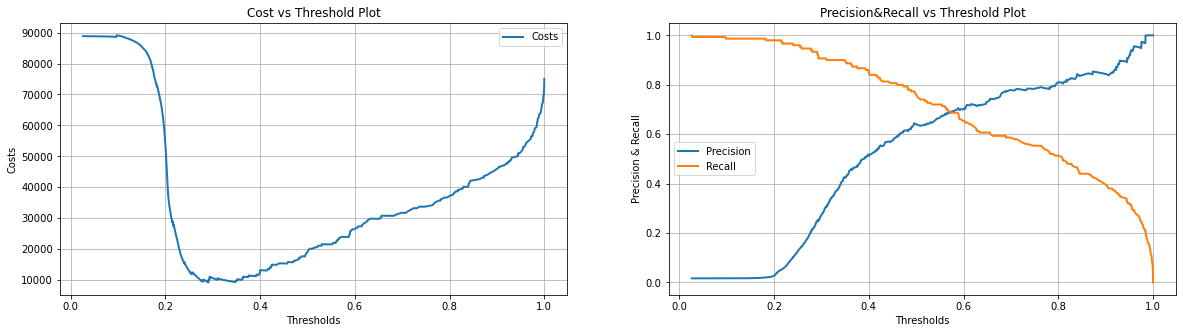

Best threshold: 0.2908
cost at this thresold: 9230.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.972  |  0.9527  |  0.9623  | 725220 |
|   CV  | 0.9333 |  0.2487  |  0.3927  |  9230  |
|  test | 0.944  |  0.313   |  0.4701  | 18270  |
+-------+--------+----------+----------+--------+


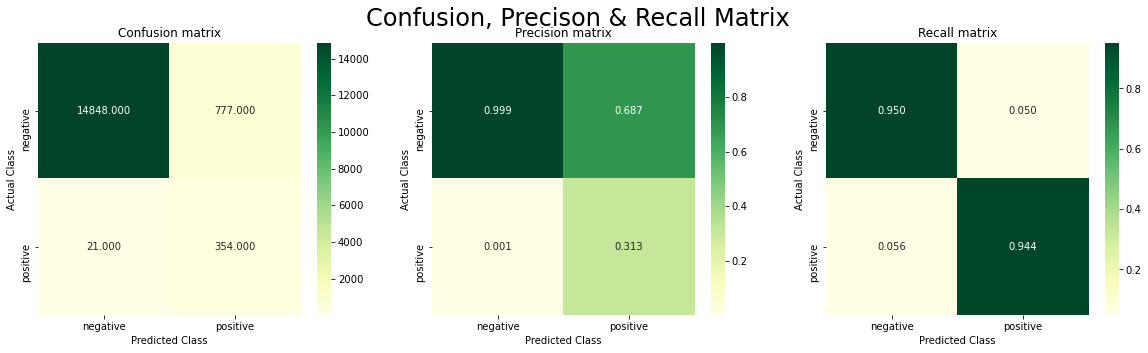

#False positives(Type 1 error) : 777
#False negatives(Type 2 error) : 21
cost : 18270


['ML models & Results/RFR_LR.pkl']

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF, y_train))
best_clf.fit(x_tr_RF,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LogisticRegression','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_LR.pkl')

### 5.5.3 LinearSVC on RandomForestRegressor_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.5min finished


Best parameters are:
 {'penalty': 'l2', 'C': 1}

Best estimator is:
 LinearSVC(C=1, random_state=42)

And it's best recall score is : 0.9558125623130607

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.7403 |  0.993   |  0.8482  | 6514110 |
|   CV  |  0.68  |  0.6667  |  0.6733  |  24510  |
|  test |  0.72  |  0.7317  |  0.7258  |  53490  |
+-------+--------+----------+----------+---------+


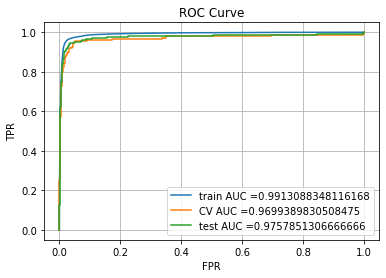

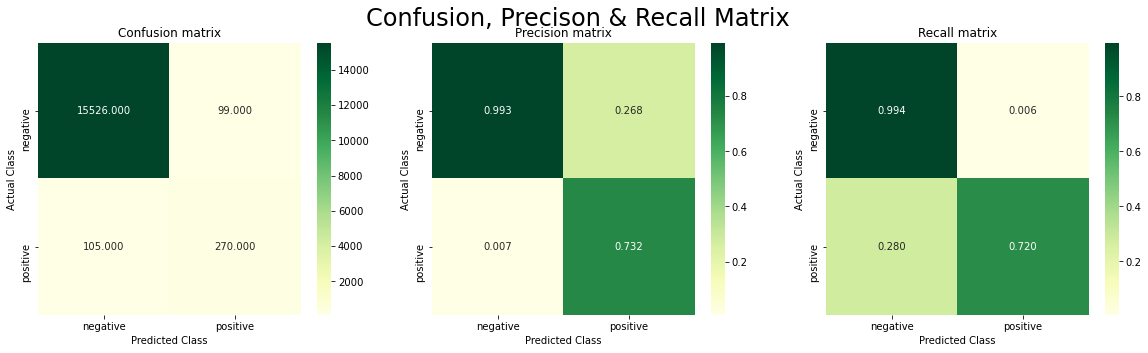

#False positives(Type 1 error) : 99
#False negatives(Type 2 error) : 105
cost : 53490
Selecting best threshold that gives lowest cost


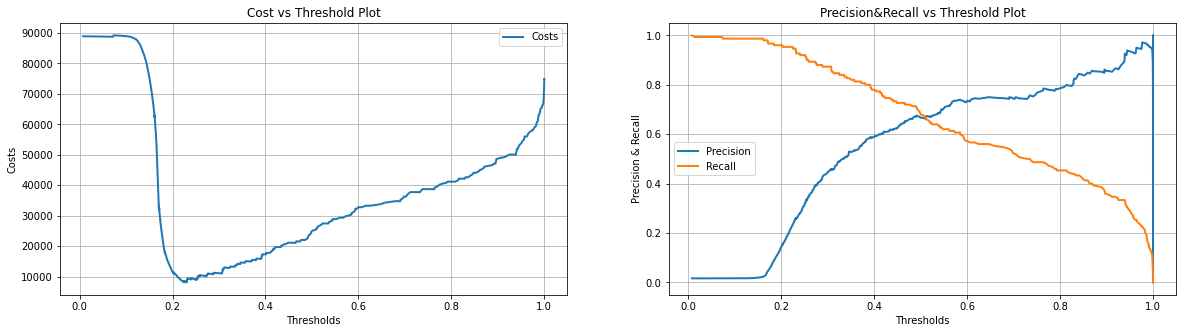

Best threshold: 0.2305
cost at this thresold: 8080.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9724 |  0.9552  |  0.9637  | 713870 |
|   CV  | 0.9467 |  0.2582  |  0.4057  |  8080  |
|  test | 0.9467 |  0.3308  |  0.4903  | 17180  |
+-------+--------+----------+----------+--------+


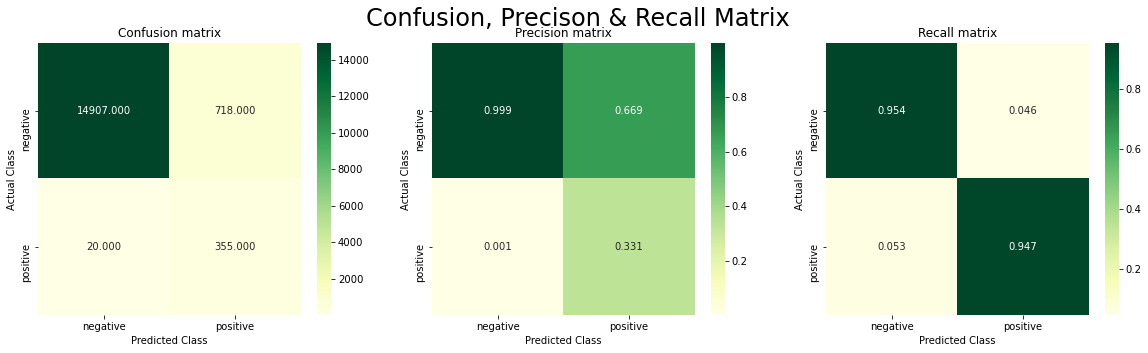

#False positives(Type 1 error) : 718
#False negatives(Type 2 error) : 20
cost : 17180


['ML models & Results/RFR_SVM.pkl']

In [44]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF, y_train))
best_clf.fit(x_tr_RF,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LinearSVM','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_SVM.pkl')

### 5.5.4 RandomForestClassifier on RandomForestRegressor_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 48.0min finished


Best parameters are:
 {'n_estimators': 300, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=10, min_samples_split=11,
                       n_estimators=300, random_state=42)

And it's best recall score is : 0.9941575274177467

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9931 |  0.9892  |  0.9912  | 177420 |
|   CV  |  0.88  |  0.4889  |  0.6286  | 10380  |
|  test | 0.9147 |  0.6364  |  0.7505  | 17960  |
+-------+--------+----------+----------+--------+


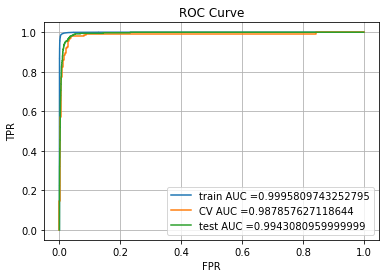

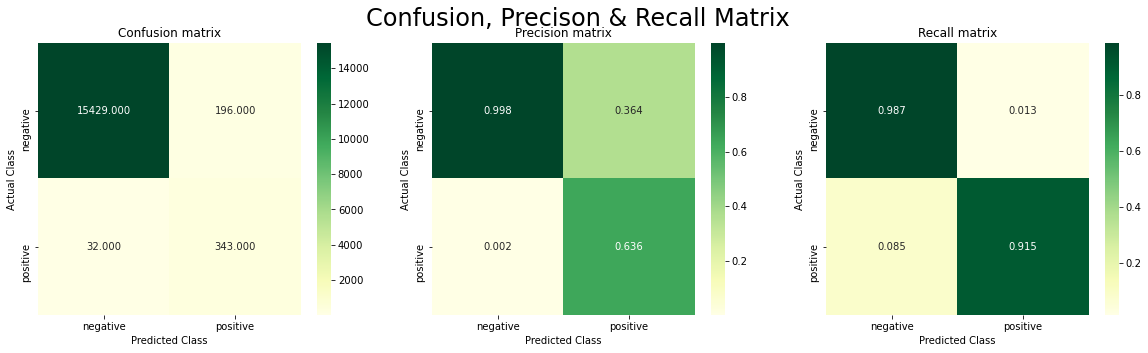

#False positives(Type 1 error) : 196
#False negatives(Type 2 error) : 32
cost : 17960
Selecting best threshold that gives lowest cost


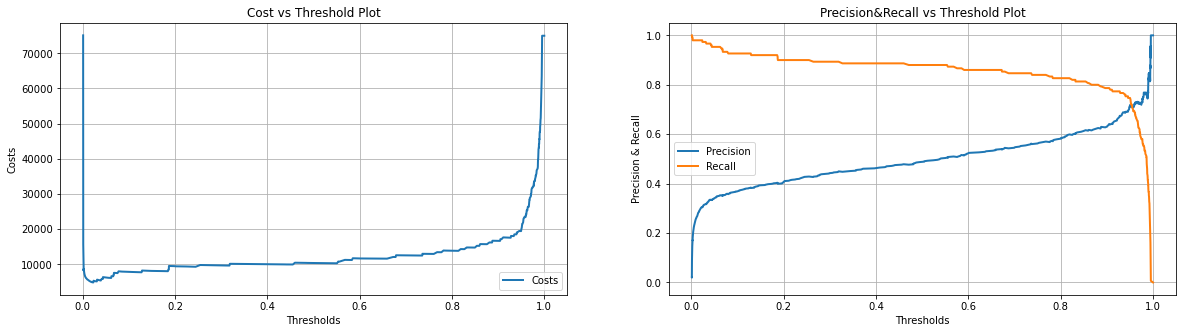

Best threshold: 0.0229
cost at this thresold: 4840.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9985 |  0.9674  |  0.9827  | 53390 |
|   CV  |  0.98  |  0.3056  |  0.4659  |  4840 |
|  test | 0.9787 |  0.3998  |  0.5677  |  9510 |
+-------+--------+----------+----------+-------+


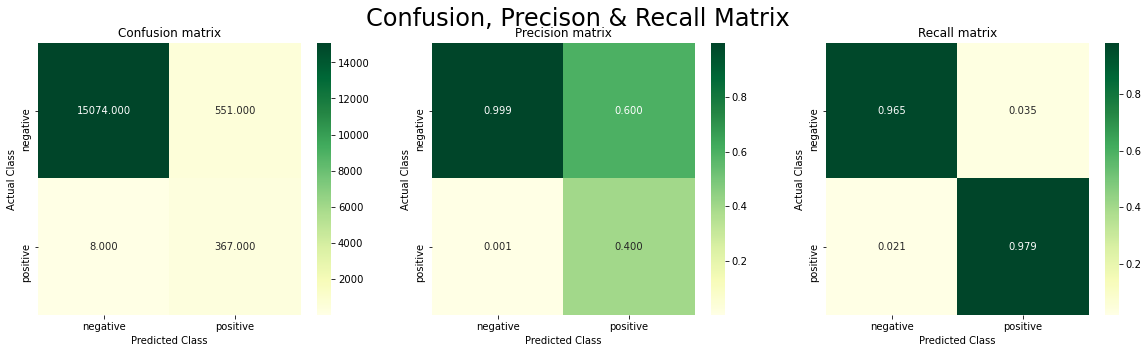

#False positives(Type 1 error) : 551
#False negatives(Type 2 error) : 8
cost : 9510


['ML models & Results/RFR_RF.pkl']

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF, y_train))
best_clf.fit(x_tr_RF,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_RF.pkl')

### 5.5.5 XGBClassifier on RandomForestRegressor_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 59.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 87.5min finished


Best parameters are:
 {'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.03, 'colsample_bytree': 1}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.9994416749750747

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9998 |   1.0

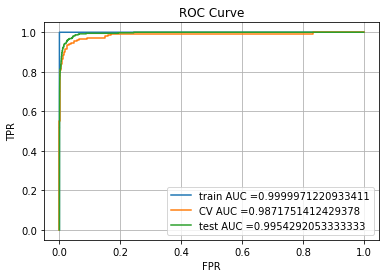

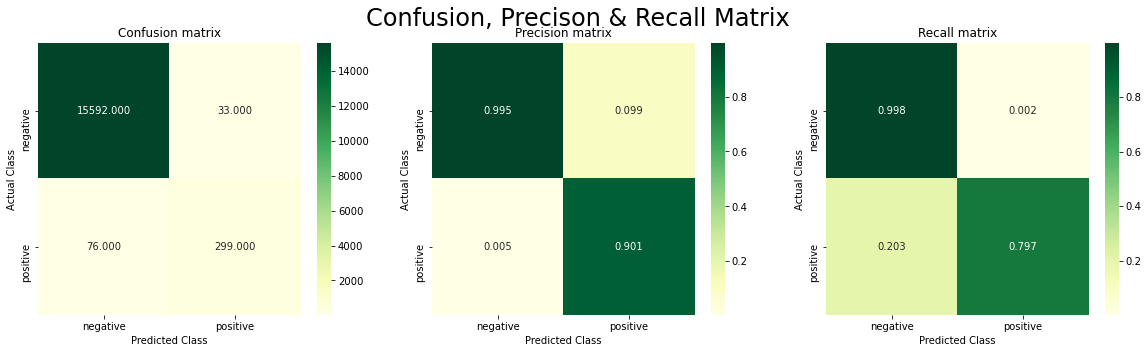

#False positives(Type 1 error) : 33
#False negatives(Type 2 error) : 76
cost : 38330
Selecting best threshold that gives lowest cost


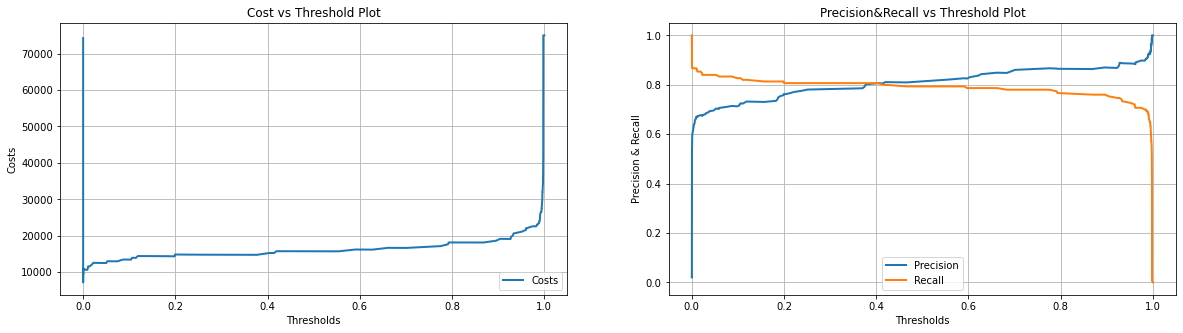

Best threshold: 0.0003
cost at this thresold: 7210.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9824  |  0.9911  | 10010 |
|   CV  | 0.9333 |  0.3878  |  0.5479  |  7210 |
|  test | 0.9467 |  0.5064  |  0.6599  | 13460 |
+-------+--------+----------+----------+-------+


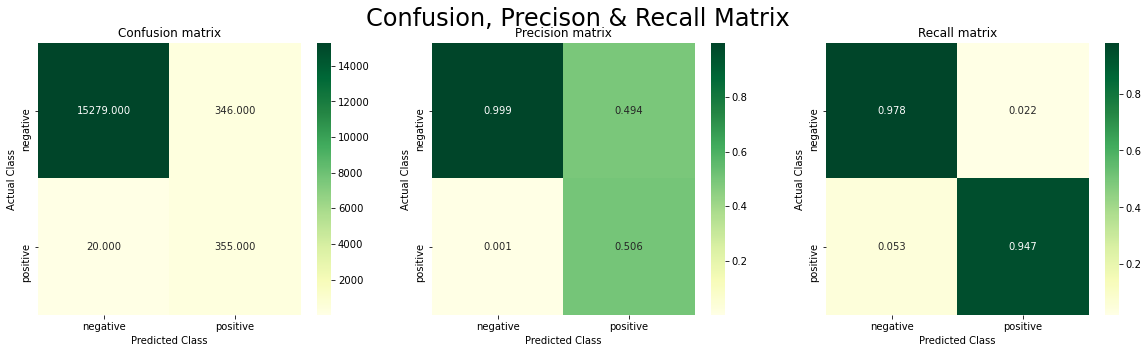

#False positives(Type 1 error) : 346
#False negatives(Type 2 error) : 20
cost : 13460


['ML models & Results/RFR_XGB.pkl']

In [46]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF, y_train))
best_clf.fit(x_tr_RF,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_XGB.pkl')

### 5.5.6 AdaBoostClassifier on RandomForestRegressor_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 59.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 69.0min finished


Best parameters are:
 {'n_estimators': 200, 'learning_rate': 0.75, 'algorithm': 'SAMME.R'}

Best estimator is:
 AdaBoostClassifier(learning_rate=0.75, n_estimators=200, random_state=42)

And it's best recall score is : 0.9878165503489532

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9908 |  0.9856  |  0.9882  | 237740 |
|   CV  | 0.8067 |  0.4337  |  0.5641  | 16080  |
|  test | 0.8853 |  0.5855  |  0.7049  | 23850  |
+-------+--------+----------+----------+--------+


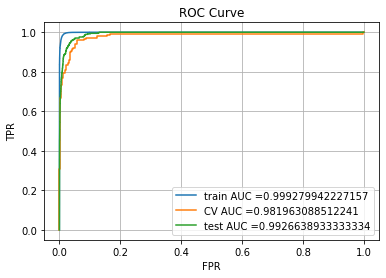

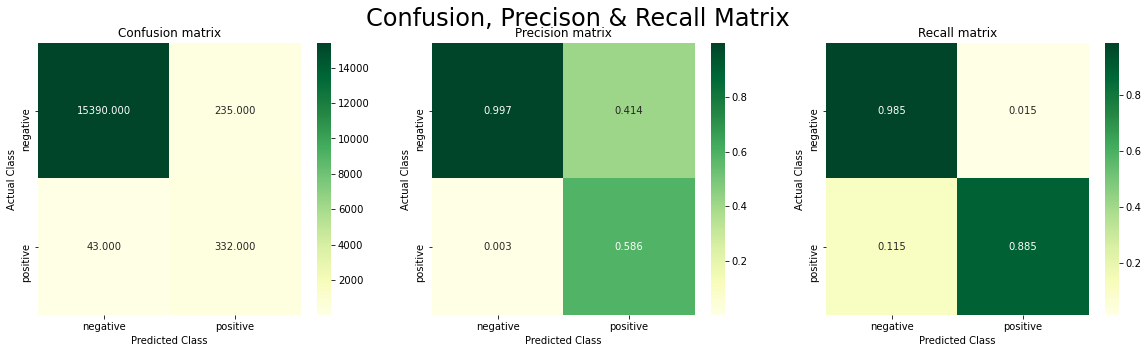

#False positives(Type 1 error) : 235
#False negatives(Type 2 error) : 43
cost : 23850
Selecting best threshold that gives lowest cost


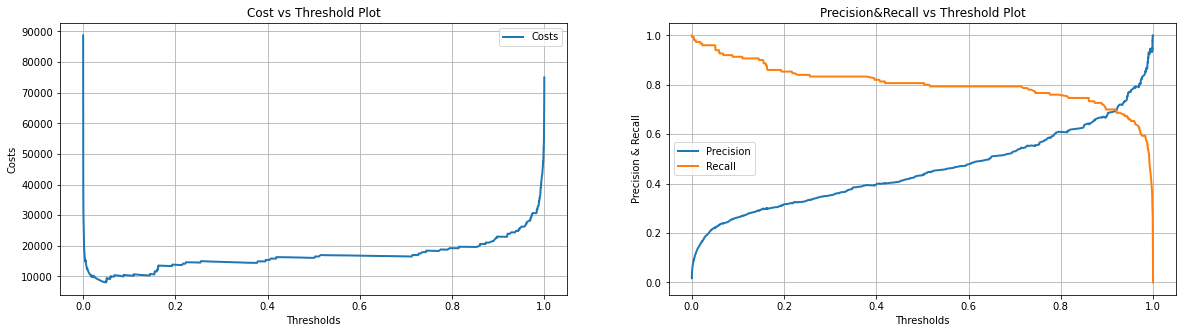

Best threshold: 0.0501
cost at this thresold: 8030.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9997 |  0.9448  |  0.9715  | 37290 |
|   CV  |  0.96  |  0.2226  |  0.3614  |  8030 |
|  test | 0.9707 |  0.2871  |  0.4431  | 14540 |
+-------+--------+----------+----------+-------+


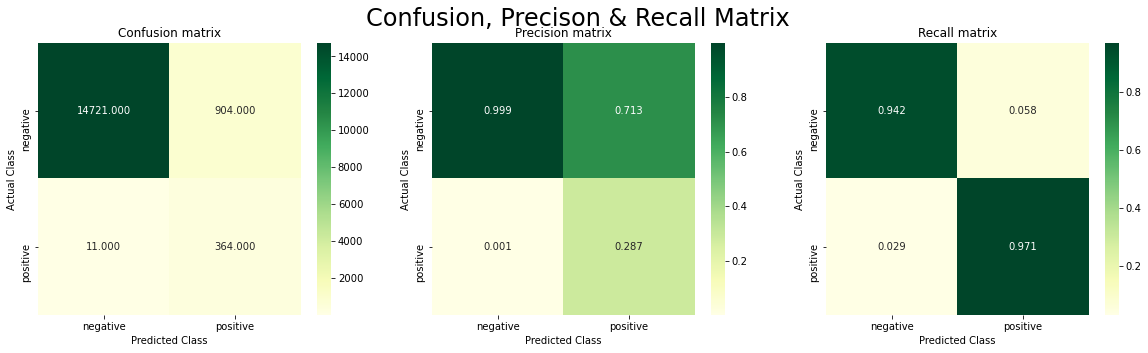

#False positives(Type 1 error) : 904
#False negatives(Type 2 error) : 11
cost : 14540


['ML models & Results/RFR_AB.pkl']

In [47]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = AdaBoostClassifier(random_state=42)
params = {
    "n_estimators": [50, 75, 100,150,200,250,400,500],
    'learning_rate':[0.01,0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1],
    'algorithm' : ['SAMME', 'SAMME.R']    
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_RF, y_train))
best_clf.fit(x_tr_RF,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, best_clf.predict(x_te_RF))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_RF)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_RF)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('AdaBoostClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_AB.pkl')

### 5.5.7 MetaLearnClassifier on RandomForestRegressor_imputer Imputed Data

Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :
 [0.96355932 0.99097707 0.98743769 0.9890329  0.99107677 0.99187438
 0.9891326  0.98928215 0.99012961 0.99037886 0.99092722]


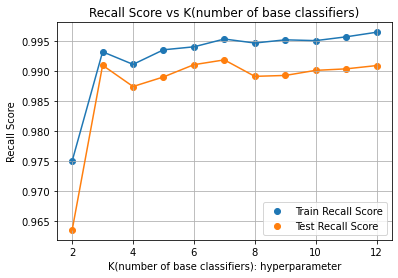

Best parameters:	 k =  7
And its best recall score is :  0.9918743768693918
So training 7 base learns and 1 metal learner on top of it.....

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9966 |  0.9946  |  0.9956  | 88200 |
|   CV  | 0.7533 |  0.5207  |  0.6158  | 19540 |
|  test |  0.72  |  0.6193  |  0.6658  | 54160 |
+-------+--------+----------+----------+-------+


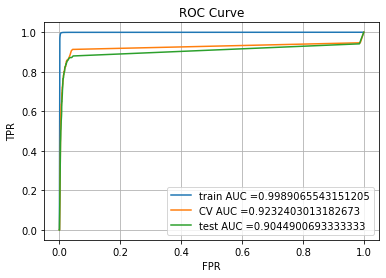

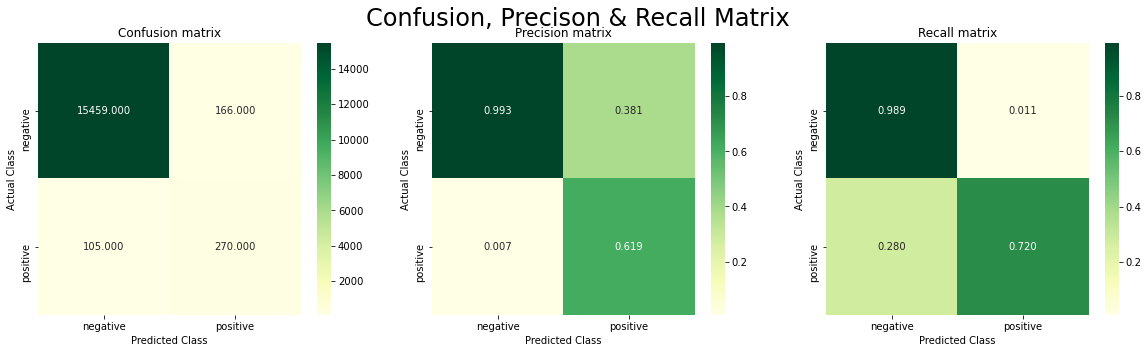

#False positives(Type 1 error) : 166
#False negatives(Type 2 error) : 105
cost : 54160
Selecting best threshold that gives lowest cost


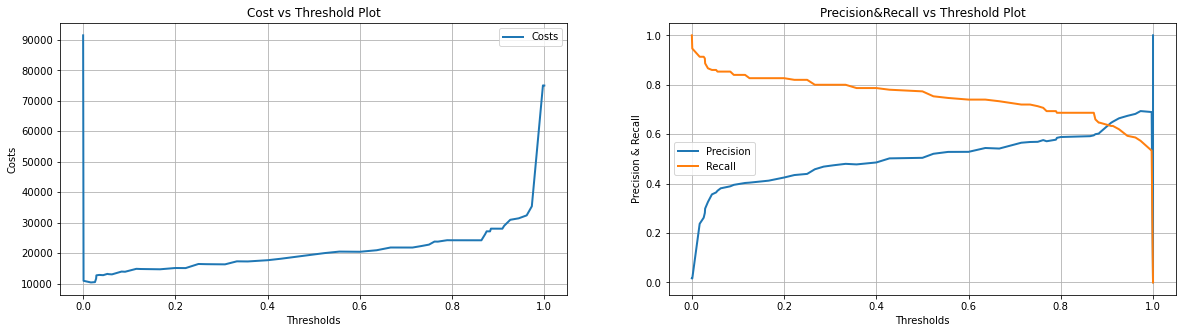

Best threshold: 0.0169
cost at this thresold: 10360.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9995 |  0.9685  |  0.9837  | 29310 |
|   CV  | 0.9133 |  0.262   |  0.4071  | 10360 |
|  test | 0.872  |  0.341   |  0.4903  | 30320 |
+-------+--------+----------+----------+-------+


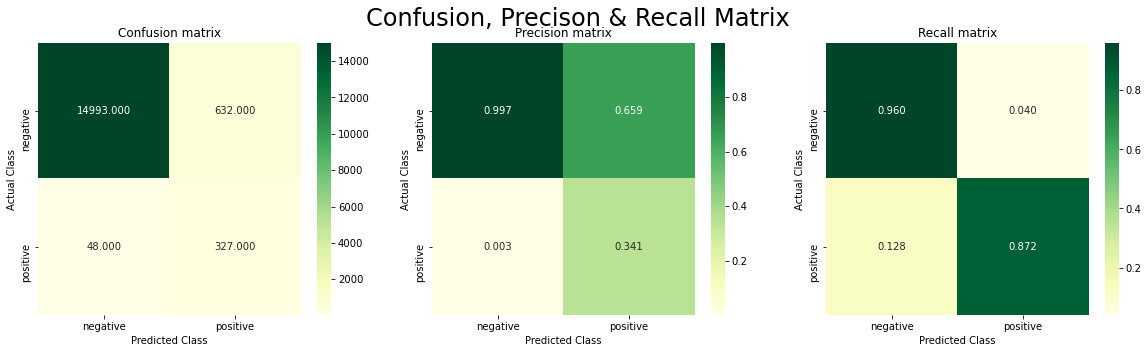

#False positives(Type 1 error) : 632
#False negatives(Type 2 error) : 48
cost : 30320


['ML models & Results/RFR_MLC.pkl']

In [48]:
#Hyperparameter tuning classifier with params
best_k, best_recall_score = hyperparameter_tuning_kflod_metaLearnClassifier(x_tr_RF, y_train)
print("Best parameters:\t k = ", best_k)
print("And its best recall score is : ", best_recall_score)

print("So training {0} base learns and 1 metal learner on top of it.....".format(best_k))
best_clf = train_metaLearnClassifier(x_tr_RF,y_train, best_k)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table_metaLearnClassifier(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_roc_curve_metaLearnClassifier(best_clf, [x_tr_RF, x_cv_RF, x_te_RF])
plot_confusion_matrix(y_test, pred_y_metaLearnClassifier(x_te_RF, best_clf))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,pred_y_metaLearnClassifier(x_cv_RF, best_clf, prob = True)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table_metaLearnClassifier(best_clf, [x_tr_RF, x_cv_RF, x_te_RF], threshold = best_threshold)
y_te_pred = pred_y_metaLearnClassifier(x_te_RF, best_clf, prob = True)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('MetalearningClassifier','RandomForestRegressor', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/RFR_MLC.pkl')

## 5.6 BayesianGaussianMixture_imputer Imputed Dataset

### 5.6.1 loading Train, CV & Test datasets & Upsampling train dataset

In [7]:
y_train = pd.read_csv('y_train.csv', header = None)
x_tr_BGM = pd.read_csv('x_tr_BGM.csv')
x_cv_BGM = pd.read_csv('x_cv_BGM.csv')
x_te_BGM = pd.read_csv('x_te_BGM.csv')

print('Shapes of Train, CV & Test data of :')
print(x_tr_BGM.shape, x_cv_BGM.shape, x_te_BGM.shape)

print('\nupsampling positive class of train data using SMOTE')
x_tr_BGM,y_train = SMOTE_upsmapling(x_tr_BGM, y_train)

Shapes of Train, CV & Test data of :
(51000, 170) (9000, 170) (16000, 170)

upsampling positive class of train data using SMOTE
class label counts before upsampling : [50150   850]
class label counts after upsampling : [50150 50150]
shapes after upsampling : (100300, 170) (100300,)


### 5.6.2 LogisticRegression on BayesianGaussianMixture_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   30.9s finished


Best parameters are:
 {'penalty': 'l2', 'C': 100}

Best estimator is:
 LogisticRegression(C=100, random_state=42)

And it's best recall score is : 0.9525423728813559

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.8664 |  0.9898  |  0.924   | 3354480 |
|   CV  | 0.7867 |  0.5784  |  0.6667  |  16860  |
|  test | 0.8293 |  0.679   |  0.7467  |  33470  |
+-------+--------+----------+----------+---------+


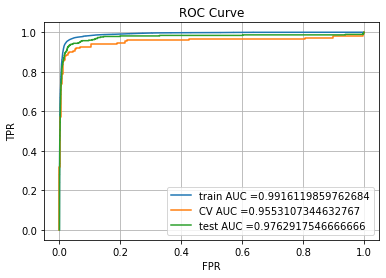

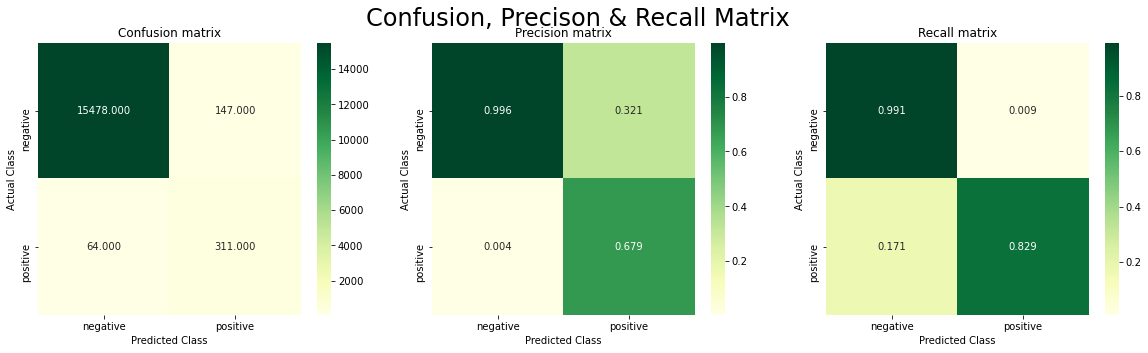

#False positives(Type 1 error) : 147
#False negatives(Type 2 error) : 64
cost : 33470
Selecting best threshold that gives lowest cost


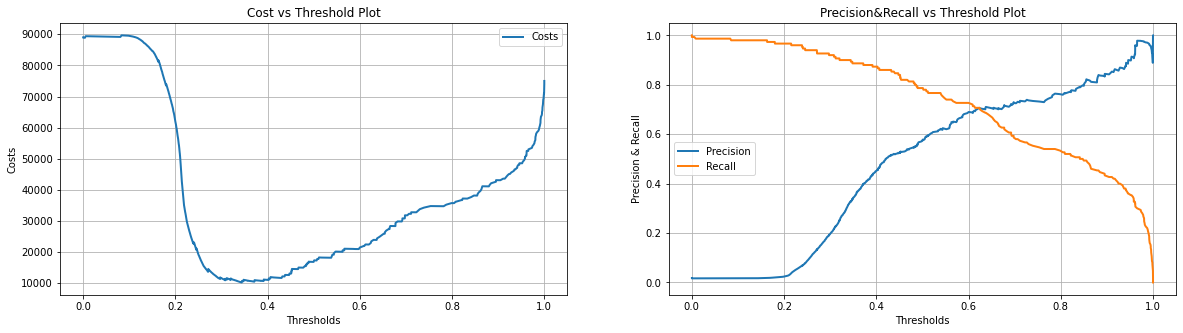

Best threshold: 0.3442
cost at this thresold: 10260.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9624 |  0.9664  |  0.9644  | 959270 |
|   CV  |  0.9   |  0.3285  |  0.4813  | 10260  |
|  test | 0.9333 |  0.4089  |  0.5686  | 17560  |
+-------+--------+----------+----------+--------+


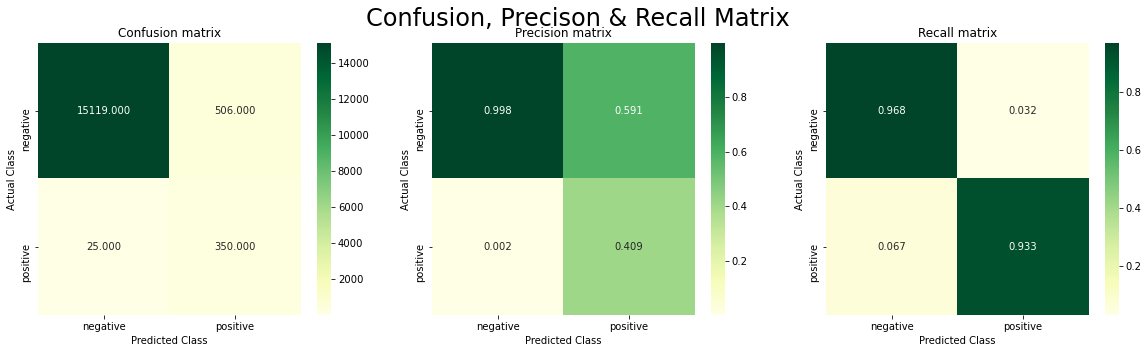

#False positives(Type 1 error) : 506
#False negatives(Type 2 error) : 25
cost : 17560


['ML models & Results/BGM_LR.pkl']

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM, y_train))
best_clf.fit(x_tr_BGM,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LogisticRegression','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_LR.pkl')

### 5.6.3 LinearSVC on BayesianGaussianMixture_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.3min finished


Best parameters are:
 {'penalty': 'l2', 'C': 1}

Best estimator is:
 LinearSVC(C=1, random_state=42)

And it's best recall score is : 0.9521435692921235

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+---------+
|  Data | Recall | Precison | F1-score |   Cost  |
+-------+--------+----------+----------+---------+
| train | 0.7369 |  0.9936  |  0.8462  | 6598890 |
|   CV  | 0.6467 |  0.6736  |  0.6599  |  26970  |
|  test |  0.72  |  0.7418  |  0.7307  |  53440  |
+-------+--------+----------+----------+---------+


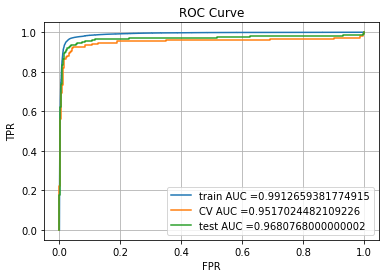

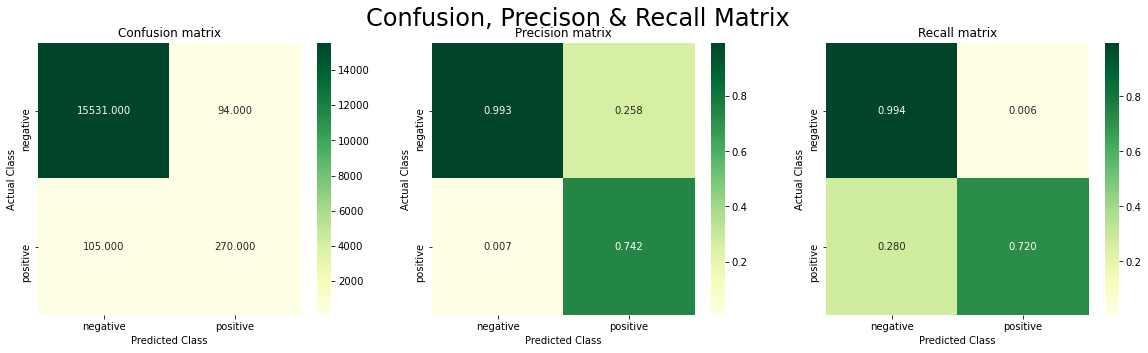

#False positives(Type 1 error) : 94
#False negatives(Type 2 error) : 105
cost : 53440
Selecting best threshold that gives lowest cost


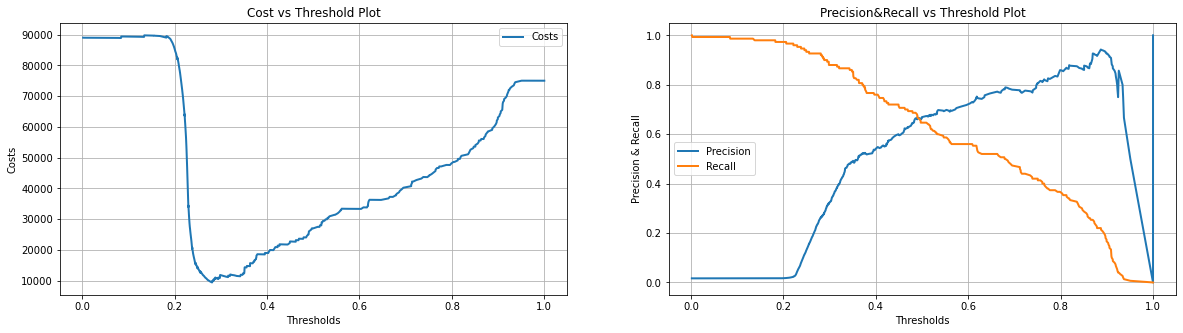

Best threshold: 0.2809
cost at this thresold: 9390.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9715 |  0.958   |  0.9647  | 735360 |
|   CV  | 0.9267 |  0.2633  |   0.41   |  9390  |
|  test | 0.936  |  0.3438  |  0.5029  | 18700  |
+-------+--------+----------+----------+--------+


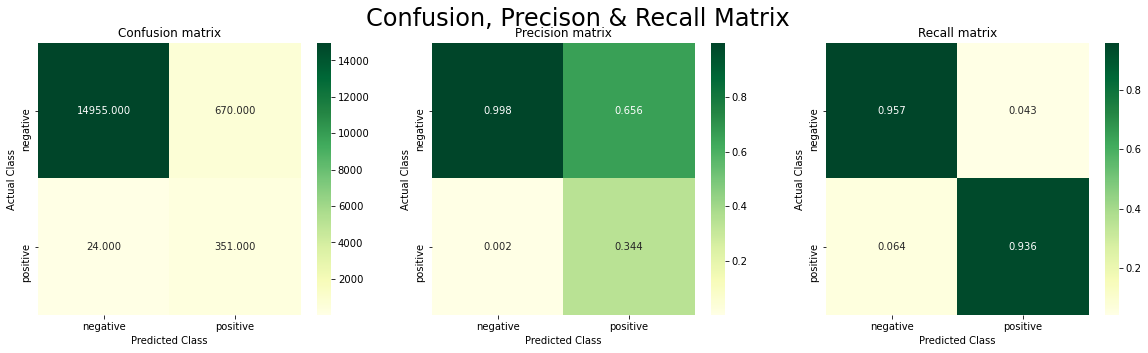

#False positives(Type 1 error) : 670
#False negatives(Type 2 error) : 24
cost : 18700


['ML models & Results/BGM_SVM.pkl']

In [51]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

clf = LinearSVC(random_state=42)
params = {'C' : [10**-4, 10**-3, 10**-2, 10**-1, 1, 10**1, 10**2, 10**3, 10**4],
          'penalty': ['l1', 'l2']
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM, y_train))
best_clf.fit(x_tr_BGM,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('LinearSVM','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_SVM.pkl')

### 5.6.4 RandomForestClassifier on BayesianGaussianMixture_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 50.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 66.1min finished


Best parameters are:
 {'n_estimators': 700, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 12}

Best estimator is:
 RandomForestClassifier(max_depth=12, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=700, random_state=42)

And it's best recall score is : 0.9941575274177469

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9938 |  0.9903  |  0.992   | 160400 |
|   CV  |  0.86  |  0.5079  |  0.6386  | 11750  |
|  test | 0.8853 |  0.6336  |  0.7386  | 23420  |
+-------+--------+----------+----------+--------+


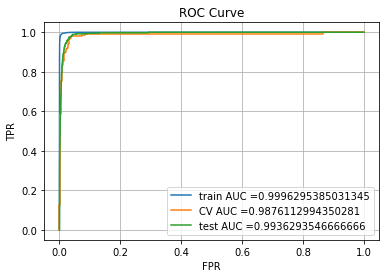

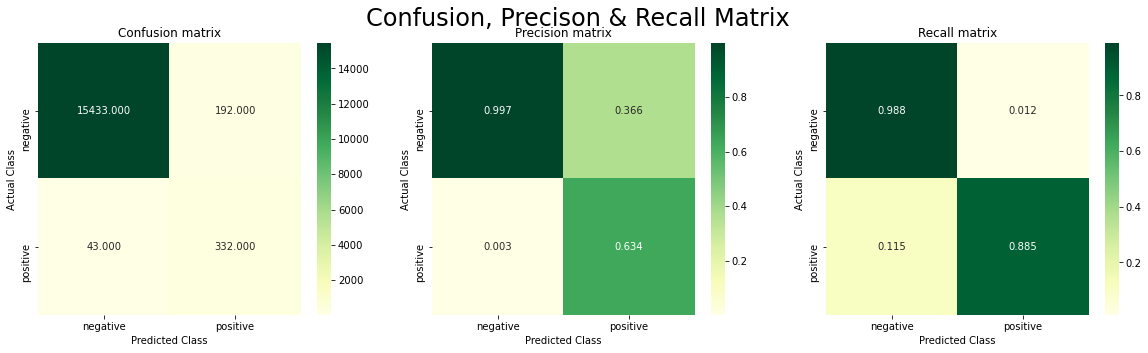

#False positives(Type 1 error) : 192
#False negatives(Type 2 error) : 43
cost : 23420
Selecting best threshold that gives lowest cost


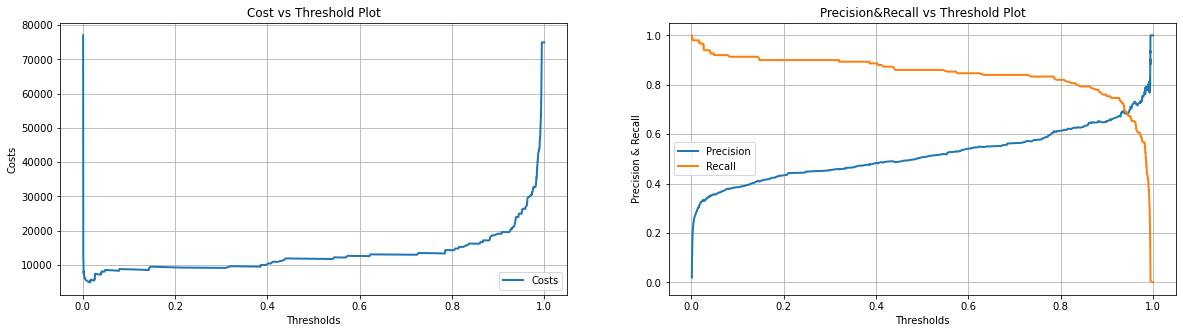

Best threshold: 0.0158
cost at this thresold: 4840.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9989 |  0.9681  |  0.9833  | 44990 |
|   CV  |  0.98  |  0.3056  |  0.4659  |  4840 |
|  test | 0.976  |  0.3987  |  0.5661  | 10020 |
+-------+--------+----------+----------+-------+


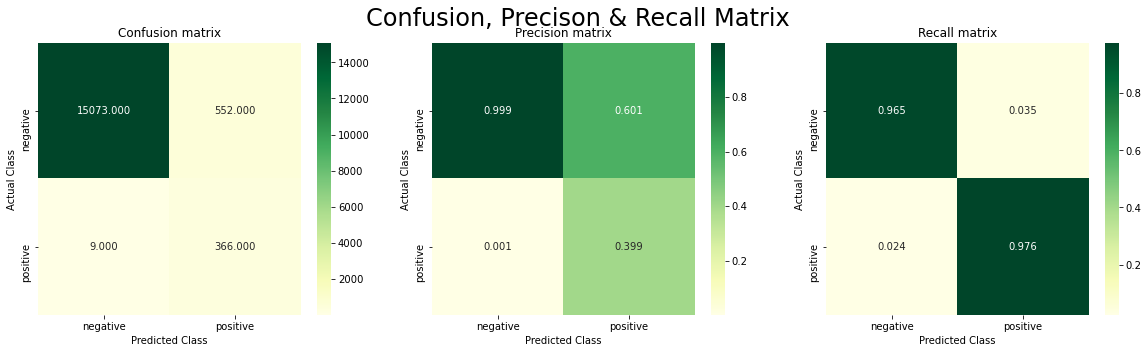

#False positives(Type 1 error) : 552
#False negatives(Type 2 error) : 9
cost : 10020


['ML models & Results/BGM_RF.pkl']

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = RandomForestClassifier(random_state=42)
params = {
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12],
        "min_samples_leaf": [1,2,3,4,5,6,7,8,9,10,11]
    }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM, y_train))
best_clf.fit(x_tr_BGM,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('RandomForestClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_RF.pkl')

### 5.6.5 XGBClassifier on BayesianGaussianMixture_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 65.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 93.0min finished


Best parameters are:
 {'subsample': 0.1, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.5}

Best estimator is:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
              tree_method='exact', validate_parameters=1, verbosity=None)

And it's best recall score is : 0.999222333000997

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9996 |  0

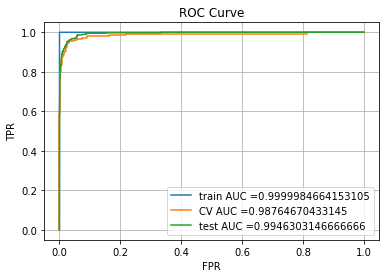

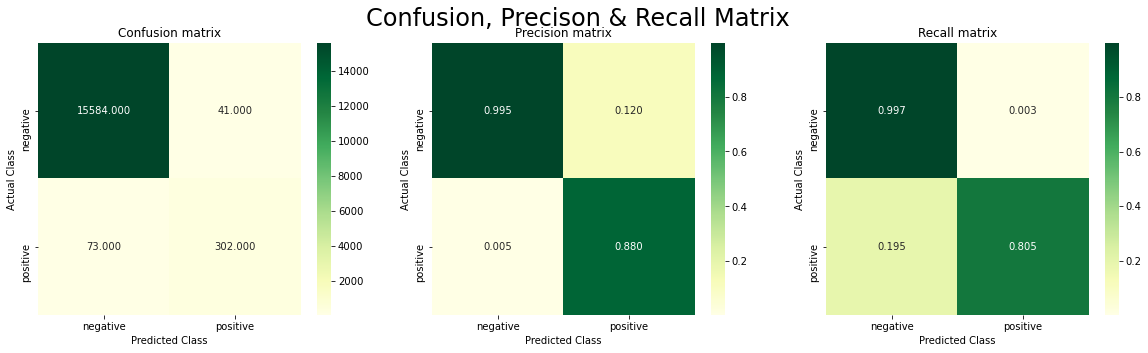

#False positives(Type 1 error) : 41
#False negatives(Type 2 error) : 73
cost : 36910
Selecting best threshold that gives lowest cost


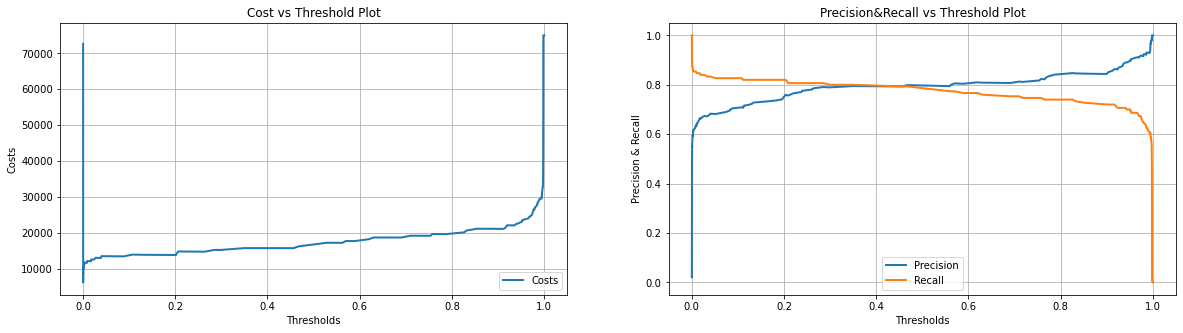

Best threshold: 0.0005
cost at this thresold: 6260.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train |  1.0   |  0.9808  |  0.9903  | 10310 |
|   CV  | 0.9467 |  0.3859  |  0.5483  |  6260 |
|  test | 0.9413 |  0.4836  |  0.6389  | 14770 |
+-------+--------+----------+----------+-------+


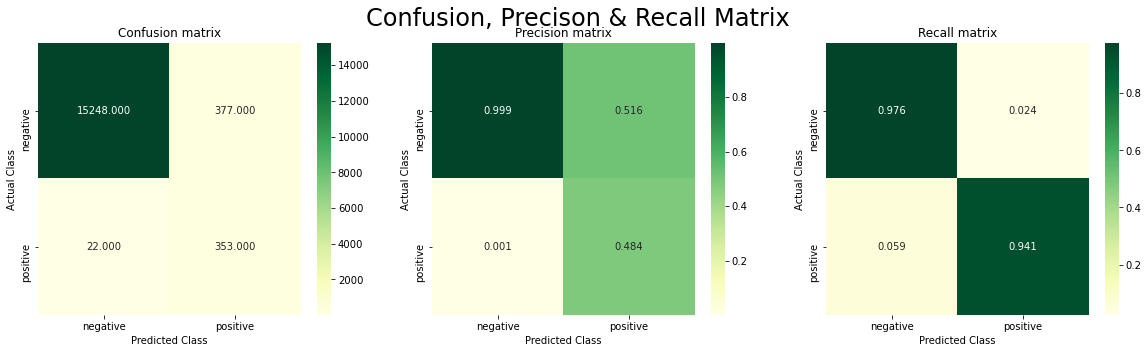

#False positives(Type 1 error) : 377
#False negatives(Type 2 error) : 22
cost : 14770


['ML models & Results/BGM_XGB.pkl']

In [53]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = XGBClassifier(random_state = 42)
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
     'max_depth':[3,4,5,6,7,8,9,10, 11, 12],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}


#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM, y_train))
best_clf.fit(x_tr_BGM,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('XGBClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_XGB.pkl')

### 5.6.6 AdaBoostClassifier on BayesianGaussianMixture_imputer Imputed Data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 68.9min finished


Best parameters are:
 {'n_estimators': 400, 'learning_rate': 1, 'algorithm': 'SAMME'}

Best estimator is:
 AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=400,
                   random_state=42)

And it's best recall score is : 0.9851246261216351

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+--------+
|  Data | Recall | Precison | F1-score |  Cost  |
+-------+--------+----------+----------+--------+
| train | 0.9887 |  0.9836  |  0.9862  | 291750 |
|   CV  | 0.8267 |  0.4218  |  0.5586  | 14700  |
|  test | 0.8827 |  0.5648  |  0.6889  | 24550  |
+-------+--------+----------+----------+--------+


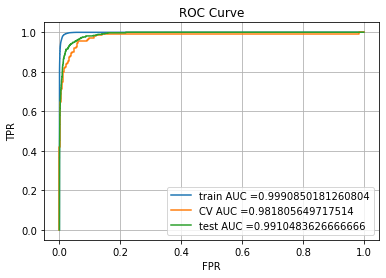

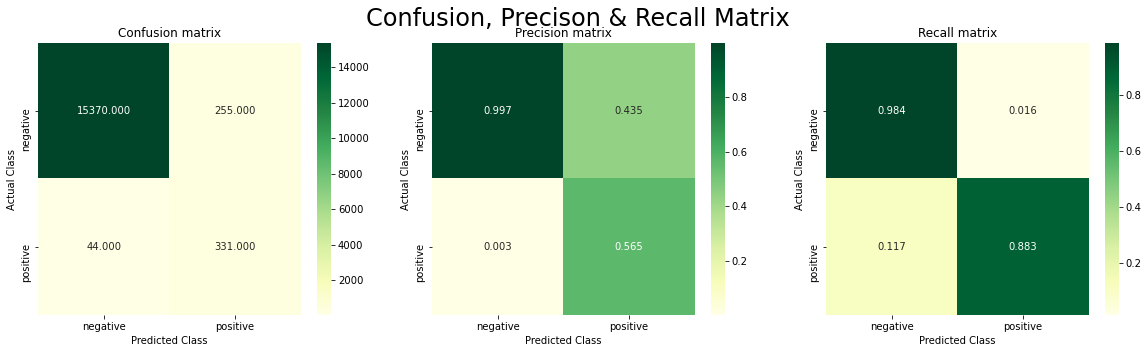

#False positives(Type 1 error) : 255
#False negatives(Type 2 error) : 44
cost : 24550
Selecting best threshold that gives lowest cost


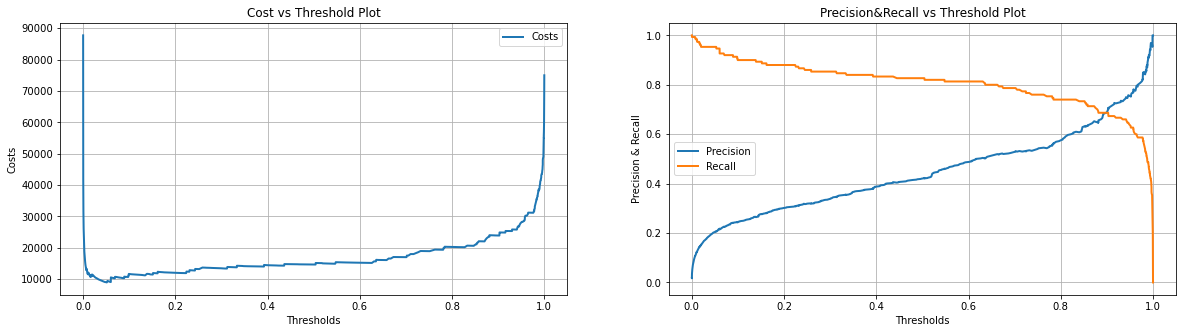

Best threshold: 0.0513
cost at this thresold: 8980.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9997 |  0.9418  |  0.9699  | 37960 |
|   CV  | 0.9533 |  0.2069  |  0.3401  |  8980 |
|  test | 0.9627 |  0.2731  |  0.4255  | 16610 |
+-------+--------+----------+----------+-------+


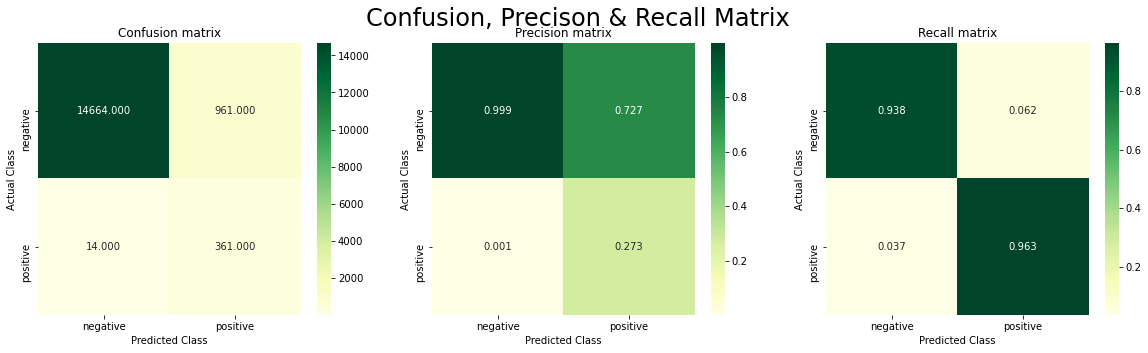

#False positives(Type 1 error) : 961
#False negatives(Type 2 error) : 14
cost : 16610


['ML models & Results/BGM_AB.pkl']

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = AdaBoostClassifier(random_state=42)
params = {
    "n_estimators": [50, 75, 100,150,200,250,400,500],
    'learning_rate':[0.01,0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 0.75, 1],
    'algorithm' : ['SAMME', 'SAMME.R']    
         }

#Hyperparameter tuning classifier with params using randomsearchcv
best_clf = CalibratedClassifierCV(model_hyperparameter_tuning(clf, params, x_tr_BGM, y_train))
best_clf.fit(x_tr_BGM,y_train)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, best_clf.predict(x_te_BGM))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,best_clf.predict_proba(x_cv_BGM)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = best_clf.predict_proba(x_te_BGM)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('AdaBoostClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_AB.pkl')

### 5.6.7 MetaLearnClassifier on BayesianGaussianMixture_imputer Imputed Data

Recall Scores for k = [2,3,4,5,6,7,8,9,10] are :
 [0.9831007  0.99167498 0.98693918 0.9890329  0.9892323  0.99172483
 0.99247258 0.99042871 0.99152542 0.99217348 0.99132602]


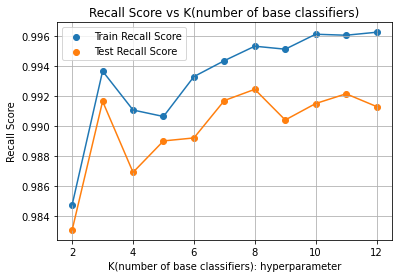

Best parameters:	 k =  8
And its best recall score is :  0.9924725822532403
So training 8 base learns and 1 metal learner on top of it.....

Metric Score Table of the best classifier model:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9972 |  0.9954  |  0.9963  | 72300 |
|   CV  |  0.72  |  0.5347  |  0.6136  | 21940 |
|  test | 0.7173 |   0.63   |  0.6708  | 54580 |
+-------+--------+----------+----------+-------+


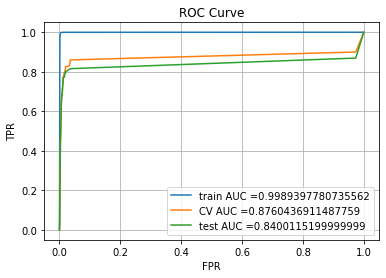

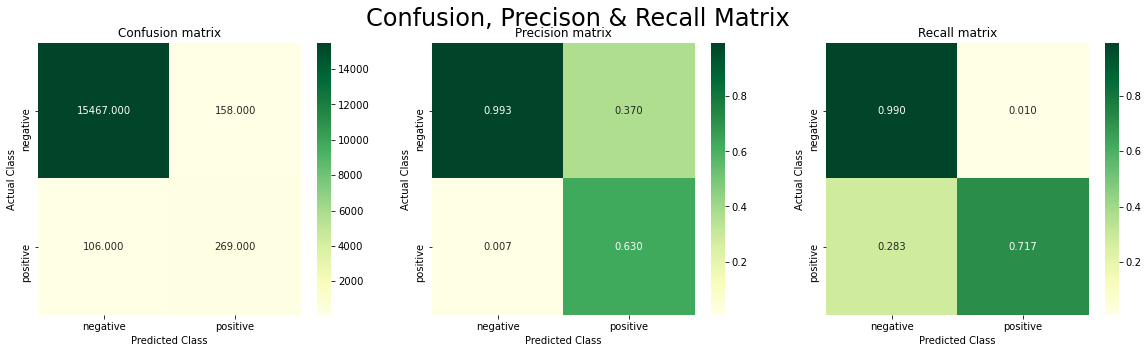

#False positives(Type 1 error) : 158
#False negatives(Type 2 error) : 106
cost : 54580
Selecting best threshold that gives lowest cost


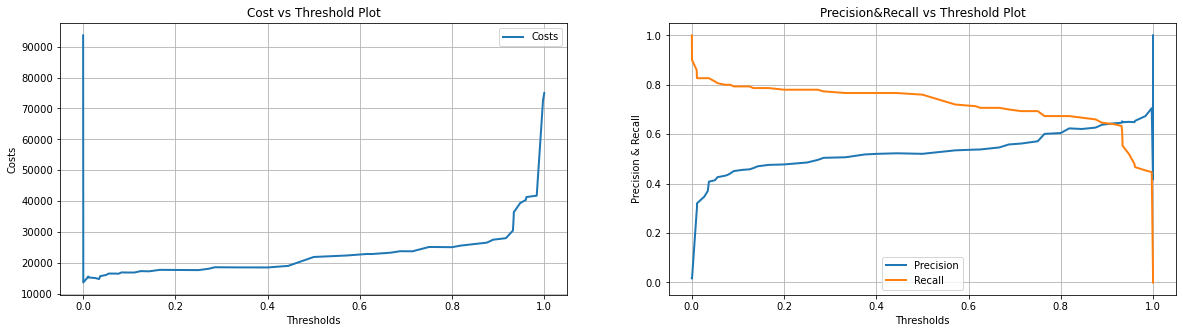

Best threshold: 0.0003
cost at this thresold: 13700.00

Metric Score Table with the best threshold:
+-------+--------+----------+----------+-------+
|  Data | Recall | Precison | F1-score |  Cost |
+-------+--------+----------+----------+-------+
| train | 0.9998 |  0.9701  |  0.9847  | 20430 |
|   CV  |  0.86  |  0.2873  |  0.4307  | 13700 |
|  test | 0.816  |  0.3294  |  0.4693  | 40730 |
+-------+--------+----------+----------+-------+


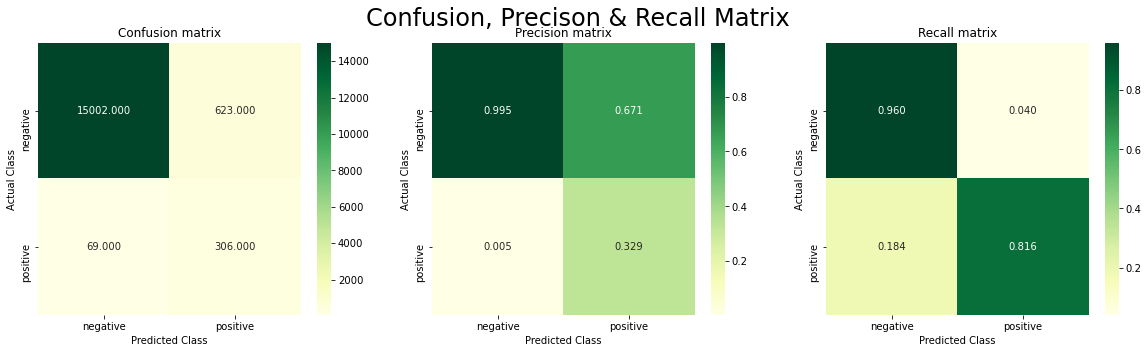

#False positives(Type 1 error) : 623
#False negatives(Type 2 error) : 69
cost : 40730


['ML models & Results/BGM_MLC.pkl']

In [9]:
#Hyperparameter tuning classifier with params
best_k, best_recall_score = hyperparameter_tuning_kflod_metaLearnClassifier(x_tr_BGM, y_train)
print("Best parameters:\t k = ", best_k)
print("And its best recall score is : ", best_recall_score)

print("So training {0} base learns and 1 metal learner on top of it.....".format(best_k))
best_clf = train_metaLearnClassifier(x_tr_BGM,y_train, best_k)

#results with the best classifier model
print('\nMetric Score Table of the best classifier model:')
score_table_metaLearnClassifier(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_roc_curve_metaLearnClassifier(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM])
plot_confusion_matrix(y_test, pred_y_metaLearnClassifier(x_te_BGM, best_clf))
print('='*125)

print('Selecting best threshold that gives lowest cost')
#Selecting the threshold value which  has lowes cost on CV data
best_threshold = select_threshold(y_cv,pred_y_metaLearnClassifier(x_cv_BGM, best_clf, prob = True)[:,1])

#Results with the best threshold value
print('\nMetric Score Table with the best threshold:')
score_table_metaLearnClassifier(best_clf, [x_tr_BGM, x_cv_BGM, x_te_BGM], threshold = best_threshold)
y_te_pred = pred_y_metaLearnClassifier(x_te_BGM, best_clf, prob = True)[:,1] > best_threshold
plot_confusion_matrix(y_test, y_te_pred)

#Saving results in results.csv & model in pkl file
save_results('MetalearningClassifier','BayesianGaussianMixture', best_threshold,y_test, y_te_pred, 'NO' )
joblib.dump(best_clf, 'ML models & Results/BGM_MLC.pkl')

## 6 Results & Summary - 1

In [2]:
#Loading results.csv file to a dataframe
results = pd.read_csv('ML models & Results/results.csv', index_col = False)
results = results[['Imputation', 'Model', 'Feature Engineering', 'Cost', 
         'Precision', 'Recall', 'F1-Score', '#FalseNegatives','#FalsePostives', 'Threshold']]
results

Imputation                   Model Feature Engineering  \
0                    median      LogisticRegression                  NO   
1                    median               LinearSVM                  NO   
2                    median  RandomForestClassifier                  NO   
3                    median           XGBClassifier                  NO   
4                    median      AdaBoostClassifier                  NO   
5                    median  MetalearningClassifier                  NO   
6                KNNimputer      LogisticRegression                  NO   
7                KNNimputer               LinearSVM                  NO   
8                KNNimputer  RandomForestClassifier                  NO   
9                KNNimputer           XGBClassifier                  NO   
10               KNNimputer      AdaBoostClassifier                  NO   
11               KNNimputer  MetalearningClassifier                  NO   
12   BayesianRidgeRegressor      LogisticRegression                  NO   
13   BayesianRidgeRegressor               LinearSVM                  NO   
14   BayesianRidgeRegressor  RandomForestClassifier                  NO   
15   BayesianRidgeRegressor           XGBClassifier                  NO   
16   BayesianRidgeRegressor      AdaBoostClassifier                  NO   
17   BayesianRidgeRegressor  MetalearningClassifier                  NO   
18    RandomForestRegressor      LogisticRegression                  NO   
19    RandomForestRegressor               LinearSVM                  NO   
20    RandomForestRegressor  RandomForestClassifier                  NO   
21    RandomForestRegressor           XGBClassifier                  NO   
22    RandomForestRegressor      AdaBoostClassifier                  NO   
23    RandomForestRegressor  MetalearningClassifier                  NO   
24  BayesianGaussianMixture      LogisticRegression                  NO   
25  BayesianGaussianMixture               LinearSVM                  NO   
26  BayesianGaussianMixture  RandomForestClassifier                  NO   
27  BayesianGaussianMixture           XGBClassifier                  NO   
28  BayesianGaussianMixture      AdaBoostClassifier                  NO   
29  BayesianGaussianMixture  MetalearningClassifier                  NO   

     Cost  Precision  Recall  F1-Score  #FalseNegatives  #FalsePostives  \
0   23390     0.5361  0.8907    0.6693               41             289   
1   17760     0.3431  0.9413    0.5028               22             676   
2    9840     0.4067  0.9760    0.5741                9             534   
3   11290     0.3502  0.9760    0.5155                9             679   
4   17180     0.2376  0.9707    0.3818               11            1168   
5   20200     0.2997  0.9360    0.4541               24             820   
6   16720     0.2916  0.9573    0.4471               16             872   
7   13720     0.3198  0.9680    0.4808               12             772   
8   10100     0.3756  0.9787    0.5429                8             610   
9   14740     0.3475  0.9573    0.5099               16             674   
10  17950     0.2479  0.9627    0.3943               14            1095   
11  35090     0.4650  0.8320    0.5966               63             359   
12  18600     0.3472  0.9360    0.5065               24             660   
13  18320     0.3755  0.9333    0.5356               25             582   
14  11120     0.3931  0.9707    0.5596               11             562   
15  11800     0.3339  0.9760    0.4976                9             730   
16  19550     0.3652  0.9280    0.5241               27             605   
17  27800     0.3451  0.8853    0.4966               43             630   
18  18270     0.3130  0.9440    0.4701               21             777   
19  17180     0.3308  0.9467    0.4903               20             718   
20   9510     0.3998  0.9787    0.5677                8             551   
21  13460     0.5064  0.9467    0.6599   

In [3]:
results.pivot('Imputation','Model', 'Cost')

Model                    AdaBoostClassifier  LinearSVM  LogisticRegression  \
Imputation                                                                   
BayesianGaussianMixture               16610      18700               17560   
BayesianRidgeRegressor                19550      18320               18600   
KNNimputer                            17950      13720               16720   
RandomForestRegressor                 14540      17180               18270   
median                                17180      17760               23390   

Model                    MetalearningClassifier  RandomForestClassifier  \
Imputation                                                                
BayesianGaussianMixture                   40730                   10020   
BayesianRidgeRegressor                    27800                   11120   
KNNimputer                                35090                   10100   
RandomForestRegressor                     30320                    9510   
median                                    20200                    9840   

Model                    XGBClassifier  
Imputation                              
BayesianGaussianMixture          14770  
BayesianRidgeRegressor           11800  
KNNimputer                       14740  
RandomForestRegressor            13460  
median                           11290

- Lowest cost 9510 achieved for RandomForestRegressor Imputed data with RandomForestClassifier

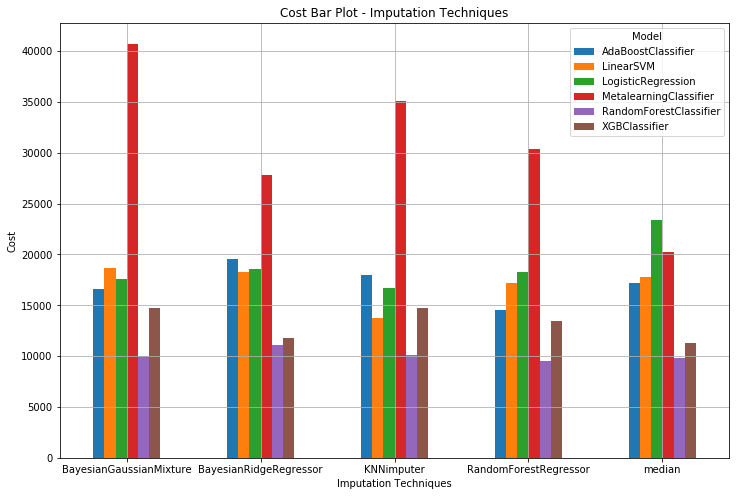

In [4]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Bar-Plot for cost for Imputation method
fig = plt.figure(figsize =(12, 8)) 
ax = fig.add_subplot(111)
results.pivot('Imputation','Model', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - Imputation Techniques', xlabel='Imputation Techniques', ylabel='Cost' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

- KNNimputer and RandomForstRegressor imputation techniques have lesser cost values while using Logistic Regression and Linear SVM models.
- While using RandomForestClassifier and XGBClassifier along with KNNImputer and RandomForestRegressor imputation techniques median, RandomForestRegressor and BayesianRidgeRegressor achieved lesser cost values.

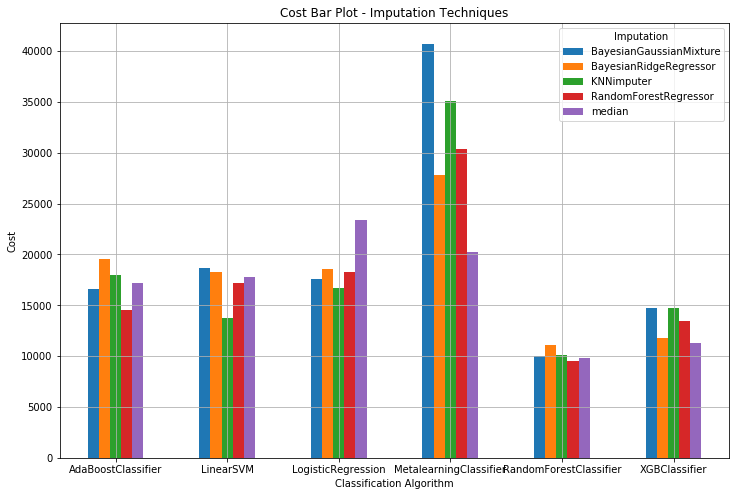

In [5]:
#grouped barplot https://stackoverflow.com/a/47797080/11479173
#rotate xtick labels https://stackoverflow.com/a/43153984/11479173
#Bar-Plot for cost for Classification Algorithm
fig = plt.figure(figsize =(12, 8)) 
ax = fig.add_subplot(111)
results.pivot('Model','Imputation', 'Cost').plot(kind = 'bar', ax = ax, grid = True)
ax.set(title = 'Cost Bar Plot - Imputation Techniques', xlabel='Classification Algorithm', ylabel='Cost' )
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.show()

- Clearly, the resulting cost values with RandomForest and XGBoost Classifiers are significantly lower.

- So for the subsequent datasets(5 variation of imputed datasets concated with missing indicators) will try out only with RandomForest and XGBoost Classifiers.